In [1]:
import tensorflow as tf
import tensorflow.contrib.eager as tfe
tf.enable_eager_execution()

#%load_ext autoreload   

#%autoreload 2

#Autoreloading of modules so you don't have to restart kernel after editing .py files

In [2]:
# import tensorflow as tf
# import tensorflow.contrib.eager as tfe
# tf.enable_eager_execution()
import random 
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from miniscope_utils_tf2 import *
import miniscope_utils as ms_utils
from miniscope_model2 import Model as msu_model
#import utils as krist
import scipy.misc as sc
import scipy.ndimage as ndim
import scipy.misc as misc
from scipy import signal
import scipy.io
from skimage.transform import resize as imresize
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
from IPython import display
from pylab import *
import os
from os import listdir
from os.path import isfile, join
import matplotlib.animation as animation
import scipy.io
import cv2

import time
from itertools import permutations
from itertools import combinations
#import copy
from bridson import poisson_disc_samples
from stl_tools import numpy2stl

In [3]:
#device = '/gpu:0'
#print(tf.test.is_gpu_available())
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [4]:
# #getting diameter vs z!
# #rlist = 1/(np.linspace(1/model.Rmax, 1/model.Rmin, model.Nlenslets))
# flist=model.rlist/0.51
# Ag=0.0725
# Cg=-0.5990
# Mag=Ag*(1-model.t/flist)+model.t*Cg
# diameter=1.22*0.510*model.t/(Mag*3.5)
# diameter

In [4]:
def distances(model, x,y):
    dist = []
    dist_bool = []
    things = np.arange(model.Nlenslets)
    test_perm = list(permutations(things, 2))

    for i in range(0, len(test_perm)):
        dist_i = tf.sqrt(tf.square(x[test_perm[i][0]]-x[test_perm[i][1]])+tf.square(y[test_perm[i][0]]-y[test_perm[i][1]]))
        dist.append(dist_i)
        dist_bool.append(dist_i>0*model.mean_lenslet_CA)  ##fix later
        
    return dist, dist_bool, test_perm

        

In [5]:
#dc_mask = np.ones_like(model.target_F.numpy())  #Mask for DC. Set to zero anywhere we want to ignore loss computation of power spectrum
#dc_mask[:3,:3] = 0
#dc_mask[-2:,:1] = 0
#dc_mask[:1,-2:] = 0
#dc_mask[-2:,-2:]= 0
#plt.figure()
#plt.plot(dc_mask)

# rlist=np.array([1,2,3,4,5])
# rliste=rlist
# posFromCenter=np.array([1,2,3,4,5])
# Indexa = np.argsort(posFromCenter)
# Indexd= np.argsort(posFromCenter)
# Indexd[::-1].sort()
# Index = np.empty((len(Indexa)+len(Indexd)),dtype=int)
# Index[::2] = Indexd
# Index[1::2] = Indexa
# Index=Index[0:len(rlist)]
# #rlist[Index]=rliste 



In [6]:
# P2=np.ones((1,2))
# while np.shape(P2)!=(36,2):
#     p=poisson_disc_samples(width=1800, height=1800, r=190)
#     np.shape(p)
#     P=np.asarray(p)

#     #scatter(P[:,0],P[:,1])
#     #plt.axis('image')
#     P2=P[(P[:,0]-900)**2+(P[:,1]-900)**2<(900-140)**2]/1000
    
#     #np.shape(P)
#     #scatter(P2[:,0],P2[:,1])
#     #plt.axis('image')
#     np.shape(P2)

In [7]:
# y=P2[:,1]
# y

In [8]:
# model.xpos=x-0.9
# model.ypos=y-0.9
# scatter(model.xpos,model.ypos)

### Initialize Model

In [9]:
model = msu_model(target_res=0.004,lenslet_CA=0.2,aberrations = True)  # zsampling options: 'fixed' or 'uniform_random'
model_init=msu_model(target_res=0.004,lenslet_CA=0.2,aberrations = True)

In [10]:
# model = msu_model()  # zsampling options: 'fixed' or 'uniform_random'
# plt.figure(figsize=(20,20))
# plt.plot(model.xg[model.samples[1]//2:model.samples[1]//2 + 50]*1000,model.target_airy.numpy()[model.samples[0]//2,model.samples[1]//2:model.samples[1]//2 + 50])
# plt.imshow(model.target_F.numpy())
# Rmat = model(0)

# find_best_init = True
# if find_best_init  == True:
#     print('Finding best initialization')
#     [xbest,ybest,rbest]=find_best_initialization(model, num_trials = 5000, save_results = True,name='36nanoscribeZemaxCorrected40_5000Birdson_20planes_160r1') 

# load_init_from_file = False

In [11]:
# xpos,ypos,rlist=poissonsampling_circular(model,factor=1.2,position_mode='random',radius_mode='random')
# plt.scatter(xpos,ypos)
# plt.axis('image')


In [12]:
# model.xpos=xpos.astype('float32')
# model.ypos=ypos.astype('float32')
# model.rlist=rlist.astype('float32')
# T,aper=make_lenslet_tf_controlr(model,0.15)
# plt.imshow(T)


In [13]:
# model.xpos=xpos.astype('float32')
# model.ypos=ypos.astype('float32')
# model.rlist=rlist.astype('float32')
# T,_=make_lenslet_tf_controlr(model,0.17)
# plt.imshow(T)

In [14]:
def load_model_from_file(model, filename):
    loaded = scipy.io.loadmat(filename)
    tf.assign(model.xpos, tfe.Variable(loaded['x_best'].ravel()))
    #model.ypos=(loaded['y_best'].ravel())
    #model.xpos=(loaded['x_best'].ravel())
    model.rlist=(loaded['r_best'].ravel())
    tf.assign(model.ypos, tfe.Variable(loaded['y_best'].ravel()))
    #tf.assign(model.rlist, tfe.Variable(loaded['r_best'].ravel()))
    return model

In [15]:
print('loading initilization from file')
file_best = '/home/kyrollos/randoscope/BestAndWorst/best_init36nanoscribeZemaxCorrected40_5000Birdson_20planes_160r1_radius.mat'
file_worst = '/home/kyrollos/randoscope/BestAndWorst/best_init36nanoscribeZemaxCorrected40_5000Birdson_20planes_160r1_radius.mat'
model = load_model_from_file(model, file_best)
    
# Save initial values for later comparison 
Rmat=model(0)


loading initilization from file


In [16]:
# rlistl=np.array([3.2977846, 4.3295083, 3.27     , 3.740349 , 7.218    , 4.3065486,
#         7.218    , 6.2587185, 3.27     , 3.5111582, 6.113198 , 4.961907 ,
#         4.917668 , 3.27     , 7.218    , 3.4650156, 4.96599  , 6.3225217,
#         3.27     , 6.2369084, 7.218    , 3.27     , 7.218    , 6.177639 ,
#         4.1532583, 7.218    , 7.218    , 3.7368193, 7.218    , 7.218    ,
#         5.9610996, 4.829266 , 3.352825 , 7.218    , 3.645886 , 3.7137387,
#         3.27     ], dtype=float32)
# xposl=np.array([ 1.6078115e-01,  7.3411775e-01,  3.3055949e-01,  7.6873653e-02,
#         -1.9657956e-01, -5.6442618e-01,  2.7790344e-01,  6.8353361e-01,
#          1.1108344e-01,  2.9256782e-01,  6.7118859e-01, -2.5596645e-01,
#          4.8388085e-01, -2.5024933e-01,  5.1971160e-02, -5.3755671e-01,
#         -6.0500002e-01, -2.2636786e-01,  1.0476543e-01, -6.9221288e-01,
#         -3.2297057e-01, -9.7859837e-02,  3.8978314e-01, -4.8055133e-01,
#          4.1953689e-01, -7.0960544e-02, -5.5910859e-02, -4.2503640e-01,
#          5.5538390e-02,  4.6847817e-01,  2.4844904e-01, -5.0409999e-05,
#          5.1052421e-01,  2.6058492e-01,  5.8567327e-01, -7.0150048e-01,
#         -2.9499999e-01], dtype=float32)
# yposl=np.array([-0.42442685,  0.02197278, -0.11147758,  0.7281471 ,  0.13611811,
#          0.3034    ,  0.19297938, -0.20399179, -0.05101691,  0.6527754 ,
#          0.2600587 ,  0.68126523,  0.5149088 ,  0.34383708,  0.1512651 ,
#          0.03441122, -0.3776683 , -0.67454255,  0.38717863, -0.2016678 ,
#         -0.08987182,  0.4894398 , -0.2841016 ,  0.5403232 , -0.5608977 ,
#         -0.08744721, -0.43789247, -0.5864714 , -0.26925528,  0.2507895 ,
#         -0.68089473, -0.66817963,  0.04163745,  0.38040164, -0.4156113 ,
#          0.17044283, -0.275     ], dtype=float32)


# rlisto=np.array([3.3724794, 6.181456 , 4.235216 , 3.659169 , 6.008875 , 5.8456683,
#         5.1467204, 6.9837832, 3.597997 , 3.3204494, 6.7642894, 6.5581717,
#         4.8022094, 3.999129 , 3.787973 , 3.8558364, 4.3202305, 4.408728 ,
#         3.27     , 5.4052353, 4.597064 , 3.7224572, 4.697398 , 7.218    ,
#         4.074845 , 5.691093 , 6.364244 , 3.48159  , 4.911805 , 5.544482 ,
#         5.272811 , 4.500927 , 5.0265193, 3.9261758, 3.4261663, 4.153483 ,
#         3.5388365], dtype=float32)

# #2500*100*5 of 5 batches
# rlistl=np.array([3.27     , 5.8502297, 4.239427 , 3.9509678, 7.218    , 4.713233 ,
#         6.951025 , 6.4384694, 3.27     , 3.5088813, 6.076159 , 5.959639 ,
#         4.6015396, 4.399678 , 5.246501 , 3.2758572, 4.4454055, 4.663368 ,
#         3.27     , 6.070035 , 5.090199 , 3.3022344, 6.7445583, 6.256204 ,
#         4.087223 , 7.213532 , 6.4714007, 3.634638 , 6.452785 , 7.218    ,
#         6.1349916, 5.439456 , 4.4348564, 5.626021 , 3.6016042, 3.7235937,
#         3.27     ], dtype=float32)
# xposl=np.array([ 1.6078115e-01,  7.1748239e-01,  3.3055949e-01,  7.6873653e-02,
#         -1.9657956e-01, -5.7268375e-01,  2.7499205e-01,  6.7711693e-01,
#          1.2711170e-01,  2.9375955e-01,  6.7118859e-01, -2.5596645e-01,
#          4.8388085e-01, -2.4532855e-01,  1.0197116e-01, -5.3755671e-01,
#         -5.7042575e-01, -2.0202032e-01,  1.0476543e-01, -6.8663383e-01,
#         -3.2297057e-01, -9.5936812e-02,  3.8978314e-01, -4.7236261e-01,
#          4.1953689e-01, -1.1947947e-01, -1.0591086e-01, -4.0754646e-01,
#          6.6806257e-02,  4.6847817e-01,  2.2894289e-01, -4.1358126e-05,
#          5.1052421e-01,  2.6218367e-01,  5.8567327e-01, -7.0392698e-01,
#         -2.9499999e-01], dtype=float32)
# yposl=np.array([-0.42442685,  0.02682625, -0.09889424,  0.7206642 ,  0.13611811,
#          0.3034    ,  0.19297938, -0.20399179, -0.05101691,  0.6497299 ,
#          0.2600587 ,  0.6814264 ,  0.50541675,  0.34383708,  0.1512651 ,
#          0.04005985, -0.425     , -0.68928075,  0.38717863, -0.2016678 ,
#         -0.08987182,  0.4894398 , -0.2841016 ,  0.5355597 , -0.5608977 ,
#         -0.10867327, -0.43789247, -0.5807456 , -0.26925528,  0.2507895 ,
#         -0.6854456 , -0.66817963,  0.04163745,  0.38040164, -0.40980738,
#          0.143447  , -0.275     ], dtype=float32)

#just learning positions
# xposl=np.array([ 0.17578115,  0.7324824 ,  0.34555948,  0.09187365, -0.21157956,
#         -0.5402    ,  0.28999206,  0.69421244,  0.10299734,  0.303706  ,
#          0.68618864, -0.2841991 ,  0.46888083, -0.27588776,  0.0767772 ,
#         -0.5525567 , -0.57      , -0.22591965,  0.08791482, -0.693723  ,
#         -0.33931562, -0.1052197 ,  0.40478313, -0.5051086 ,  0.4045369 ,
#         -0.08447947, -0.09091086, -0.3900364 ,  0.05180626,  0.48347816,
#          0.24394289,  0.02650596,  0.5255242 ,  0.2755849 ,  0.62067324,
#         -0.7252318 , -0.32522455], dtype=float32)
# yposl=np.array([-0.43942684,  0.0087904 , -0.07720638,  0.7131471 ,  0.12111811,
#          0.2684    ,  0.15797938, -0.23899178, -0.06601691,  0.6847299 ,
#          0.24505869,  0.66086996,  0.53915256,  0.3686992 ,  0.18616977,
#          0.02505985, -0.41      , -0.7095426 ,  0.40217862, -0.2166678 ,
#         -0.05666433,  0.5044398 , -0.29910162,  0.5276625 , -0.54589766,
#         -0.10244721, -0.45289245, -0.57147133, -0.28425527,  0.2657895 ,
#         -0.70100594, -0.6331796 ,  0.00764467,  0.40803543, -0.42228377,
#          0.17431541, -0.30963156], dtype=float32)


#printed parametrs?
# xposl=np.array([ 0.18578115,  0.74248238,  0.35555949,  0.10187365, -0.22157956,
#        -0.5502,  0.29999206,  0.68421244,  0.11299734,  0.3125789 ,
#         0.69618861, -0.28096646,  0.45888084, -0.27032854,  0.07697116,
#        -0.5625567 , -0.58, -0.22702032,  0.07976543, -0.70372301,
#        -0.34797056, -0.1152197 ,  0.41478314, -0.49736261,  0.39453689,
#        -0.09447947, -0.08091086, -0.40003641,  0.04180626,  0.49347817,
#         0.25394288,  0.02494959,  0.53552421,  0.28558491,  0.61067326,
#        -0.72650046,-0.32], dtype=float32)
# yposl=np.array([-0.44942685,  0.0187904 , -0.08720638,  0.7031471 ,  0.11111811,
#         0.2784 ,  0.16797938, -0.22899178, -0.07601691,  0.67472988,
#         0.23505869,  0.65642641,  0.52935778,  0.36883709,  0.1762651 ,
#         0.01505985, -0.4, -0.69954257,  0.41217862, -0.2266678 ,
#        -0.06487182,  0.51443979, -0.30910161,  0.51766252, -0.53589769,
#        -0.11244721, -0.46289246, -0.56147136, -0.29425527,  0.2757895 ,
#        -0.69100594, -0.64317962,  0.01663745,  0.40540164, -0.42807524,
#         0.168447,-0.3  ], dtype=float32)
# rlistl=np.array([4.000442 , 4.440296 , 3.7237842, 3.5596673, 3.2063835, 5.4982405,
#        4.2089086, 3.0839548, 5.3172565, 3.1439776, 6.364798 , 3.4829168,
#        2.767    , 4.3215075, 4.839368 , 4.988825 , 2.8152227, 5.1478076,
#        3.409406 , 6.9092703, 4.6986055, 3.2713168, 5.691979 , 4.5658   ,
#        4.1020284, 2.970532 , 6.625868 , 7.218    , 3.8116512, 5.8998694,
#        2.865156 , 3.6398768, 3.9037654, 2.9168925, 3.3389342, 3.026181 ,
#        6.123522 ], dtype=float32) #old rlist

# tf.assign(model.xpos, tfe.Variable(xposl))
# tf.assign(model.ypos, tfe.Variable(yposl))
# tf.assign(model.rlist, tfe.Variable(rlistl))
#more iterations with no randomization


In [17]:
#1500 iterations no aberrations. 
# <tf.Variable 'lenslet_CA:0' shape=(37,) dtype=float32, numpy=
#  array([0.2       , 0.225     , 0.20351408, 0.2       , 0.21659318,
#         0.2       , 0.225     , 0.225     , 0.2       , 0.22434336,
#         0.20952044, 0.225     , 0.22153628, 0.20512304, 0.2       ,
#         0.2       , 0.225     , 0.225     , 0.21418631, 0.224589  ,
#         0.20916918, 0.2       , 0.22342955, 0.21780339, 0.225     ,
#         0.225     , 0.20741974, 0.21026511, 0.225     , 0.21300973,
#         0.22251664, 0.20350587, 0.2       , 0.2010123 , 0.22063793,
#         0.225     , 0.2       ], dtype=float32)>,
#  <tf.Variable 'rlist:0' shape=(37,) dtype=float32, numpy=
#  array([3.579372 , 6.3215117, 3.5511532, 3.6175106, 6.381209 , 6.3213487,
#         6.115073 , 6.1346755, 3.6088037, 3.6795776, 6.3565674, 6.4081926,
#         4.5291114, 4.5330796, 3.5974433, 3.588544 , 4.546335 , 4.5292926,
#         5.0099177, 6.2620344, 4.480239 , 3.604219 , 5.140441 , 6.3063774,
#         4.945063 , 6.5380077, 6.334721 , 3.5658069, 5.6332912, 6.27728  ,
#         4.6274242, 4.6326003, 4.441186 , 3.5121613, 3.581869 , 4.442561 ,
#         3.5735552], dtype=float32)>,
#  <tf.Variable 'xpos:0' shape=(37,) dtype=float32, numpy=
#  array([ 0.1290444 ,  0.8007542 ,  0.33905914,  0.08683294, -0.26054552,
#         -0.5336107 ,  0.20869851,  0.72149205,  0.09071364,  0.33566257,
#          0.72254056, -0.31543112,  0.49502355, -0.2680371 ,  0.03894657,
#         -0.58386695, -0.6192424 , -0.31175506,  0.08917376, -0.73372626,
#         -0.37538671, -0.16534346,  0.37276292, -0.576771  ,  0.44907346,
#         -0.1254501 , -0.17692398, -0.46798775,  0.06807567,  0.47845447,
#          0.23308222,  0.02613695,  0.52904844,  0.24750584,  0.5987227 ,
#         -0.82886356, -0.39824653], dtype=float32)>,
#  <tf.Variable 'ypos:0' shape=(37,) dtype=float32, numpy=
#  array([-0.4830657 ,  0.02693111, -0.09198204,  0.8079346 ,  0.15319423,
#          0.2974461 ,  0.16257602, -0.26277515, -0.08211189,  0.70087284,
#          0.28233203,  0.7290604 ,  0.58880466,  0.4174643 ,  0.17498375,
#          0.00920908, -0.42261747, -0.769223  ,  0.37083614, -0.19825596,
#         -0.05834501,  0.5422946 , -0.3112382 ,  0.58564353, -0.5436802 ,
#         -0.14332776, -0.48431444, -0.5744155 , -0.26780945,  0.271665  ,
#         -0.7948249 , -0.7464999 ,  0.03691763,  0.49718684, -0.46334887,
#          0.22291303, -0.2914242 ], dtype=float32)>,
#  <tf.Variable 'rlist:0' shape=(37,) dtype=float32, numpy=
#  array([3.579372 , 6.3215117, 3.5511532, 3.6175106, 6.381209 , 6.3213487,
#         6.115073 , 6.1346755, 3.6088037, 3.6795776, 6.3565674, 6.4081926,
#         4.5291114, 4.5330796, 3.5974433, 3.588544 , 4.546335 , 4.5292926,
#         5.0099177, 6.2620344, 4.480239 , 3.604219 , 5.140441 , 6.3063774,
#         4.945063 , 6.5380077, 6.334721 , 3.5658069, 5.6332912, 6.27728  ,
#         4.6274242, 4.6326003, 4.441186 , 3.5121613, 3.581869 , 4.442561 ,
#         3.5735552], dtype=float32)>]

In [18]:
# rlistl=np.array([3.579372 , 6.3215117, 3.5511532, 3.6175106, 6.381209 , 6.3213487,
#         6.115073 , 6.1346755, 3.6088037, 3.6795776, 6.3565674, 6.4081926,
#         4.5291114, 4.5330796, 3.5974433, 3.588544 , 4.546335 , 4.5292926,
#         5.0099177, 6.2620344, 4.480239 , 3.604219 , 5.140441 , 6.3063774,
#         4.945063 , 6.5380077, 6.334721 , 3.5658069, 5.6332912, 6.27728  ,
#         4.6274242, 4.6326003, 4.441186 , 3.5121613, 3.581869 , 4.442561 ,
#         3.5735552])
# xposl=np.array([ 0.1290444 ,  0.8007542 ,  0.33905914,  0.08683294, -0.26054552,
#         -0.5336107 ,  0.20869851,  0.72149205,  0.09071364,  0.33566257,
#          0.72254056, -0.31543112,  0.49502355, -0.2680371 ,  0.03894657,
#         -0.58386695, -0.6192424 , -0.31175506,  0.08917376, -0.73372626,
#         -0.37538671, -0.16534346,  0.37276292, -0.576771  ,  0.44907346,
#         -0.1254501 , -0.17692398, -0.46798775,  0.06807567,  0.47845447,
#          0.23308222,  0.02613695,  0.52904844,  0.24750584,  0.5987227 ,
#         -0.82886356, -0.39824653])
# yposl=np.array([-0.4830657 ,  0.02693111, -0.09198204,  0.8079346 ,  0.15319423,
#          0.2974461 ,  0.16257602, -0.26277515, -0.08211189,  0.70087284,
#          0.28233203,  0.7290604 ,  0.58880466,  0.4174643 ,  0.17498375,
#          0.00920908, -0.42261747, -0.769223  ,  0.37083614, -0.19825596,
#         -0.05834501,  0.5422946 , -0.3112382 ,  0.58564353, -0.5436802 ,
#         -0.14332776, -0.48431444, -0.5744155 , -0.26780945,  0.271665  ,
#         -0.7948249 , -0.7464999 ,  0.03691763,  0.49718684, -0.46334887,
#          0.22291303, -0.2914242 ])
# CAl=np.array([0.2       , 0.225     , 0.20351408, 0.2       , 0.21659318,
#         0.2       , 0.225     , 0.225     , 0.2       , 0.22434336,
#         0.20952044, 0.225     , 0.22153628, 0.20512304, 0.2       ,
#         0.2       , 0.225     , 0.225     , 0.21418631, 0.224589  ,
#         0.20916918, 0.2       , 0.22342955, 0.21780339, 0.225     ,
#         0.225     , 0.20741974, 0.21026511, 0.225     , 0.21300973,
#         0.22251664, 0.20350587, 0.2       , 0.2010123 , 0.22063793,
#         0.225     , 0.2       ])

In [19]:
# x=np.array([ 0.17578115,  0.7324824 ,  0.34555948,  0.09187365, -0.21157956,
#         -0.5402    ,  0.28999206,  0.69421244,  0.10299734,  0.303706  ,
#          0.68618864, -0.2841991 ,  0.46888083, -0.27588776,  0.0767772 ,
#         -0.5525567 , -0.57      , -0.22591965,  0.08791482, -0.693723  ,
#         -0.33931562, -0.1052197 ,  0.40478313, -0.5051086 ,  0.4045369 ,
#         -0.08447947, -0.09091086, -0.3900364 ,  0.05180626,  0.48347816,
#          0.24394289,  0.02650596,  0.5255242 ,  0.2755849 ,  0.62067324,
#         -0.7252318 , -0.32522455])
# y=np.array([-0.43942684,  0.0087904 , -0.07720638,  0.7131471 ,  0.12111811,
#          0.2684    ,  0.15797938, -0.23899178, -0.06601691,  0.6847299 ,
#          0.24505869,  0.66086996,  0.53915256,  0.3686992 ,  0.18616977,
#          0.02505985, -0.41      , -0.7095426 ,  0.40217862, -0.2166678 ,
#         -0.05666433,  0.5044398 , -0.29910162,  0.5276625 , -0.54589766,
#         -0.10244721, -0.45289245, -0.57147133, -0.28425527,  0.2657895 ,
#         -0.70100594, -0.6331796 ,  0.00764467,  0.40803543, -0.42228377,
#          0.17431541, -0.30963156])




tf.Tensor(172229.47, shape=(), dtype=float32)


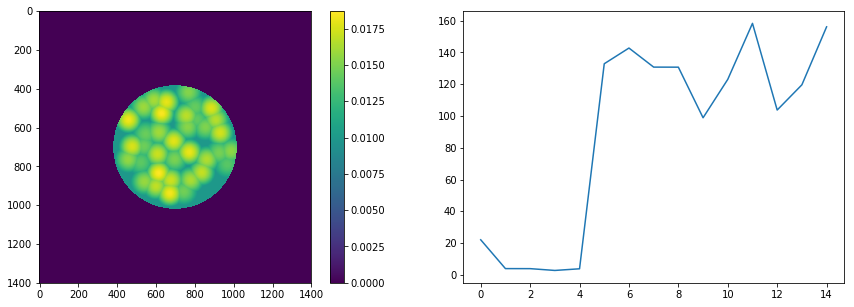

In [20]:
# [xnew,ynew]=bridson_poisson_N(H=1800,W=1800,Nlenslets=36,CA=900,r1 = 170, r2 = 75)
# model.xpos=xnew
# model.ypos=ynew
Rmat=model(0)
#model.Nz=60
# Save initial values for later comparison 
R_init = Rmat
Tinit,_,_=make_lenslet_tf_zern(model)

xinit = tfe.Variable(tf.zeros(model.Nlenslets));       tf.assign(xinit, model.xpos)
yinit = tfe.Variable(tf.zeros(model.Nlenslets));       tf.assign(yinit, model.ypos)
##rinit = tfe.Variable(tf.zeros(model.Nlenslets));       tf.assign(rinit, model.rlist)
rinit=model.rlist
#offsetinit = tfe.Variable(tf.zeros(model.Nlenslets));  tf.assign(offsetinit, model.lenslet_offset)
#zerninit = tfe.Variable(tf.zeros((model.Nlenslets, model.numzern))); tf.assign(zerninit, model.zernlist)
##CAinit = tfe.Variable(tf.zeros((model.Nlenslets))); tf.assign(CAinit, model.mean_lenslet_CA)



# tf.assign(model_init.xpos, xinit)
# tf.assign(model_init.ypos, yinit)


# xinit = (tf.zeros(model.Nlenslets));       xinit=model.xpos
# yinit = (tf.zeros(model.Nlenslets));       yinit= model.ypos
# #rinit = tfe.Variable(tf.zeros(model.Nlenslets));       tf.assign(rinit, model.rlist)
# rinit=tf.constant(tf.zeros(model.Nlenslets)); rinit=model.rlist
# #offsetinit = tfe.Variable(tf.zeros(model.Nlenslets));  tf.assign(offsetinit, model.lenslet_offset)
# zerninit = tfe.Variable(tf.zeros((model.Nlenslets, model.numzern))); tf.assign(zerninit, model.zernlist)



# model_init.xpos= xinit
# model_init.ypos= yinit

# model.rlist=rinit
model_init.rlist=rinit
#tf.assign(model_init.rlist, rinit)
#tf.assign(model_init.lenslet_offset, offsetinit)
#tf.assign(model_init.zernlist, zerninit)
#zernlist=zerninit
Rmat_init = model_init(0)
aper = tf.sqrt(model.xgm**2+model.ygm**2) <= model.CA
aper2=tf.sqrt(model.xgm**2+model.ygm**2) >= model.CA

fig=plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.imshow(0.01*aper.numpy()+Tinit.numpy())
plt.colorbar()
plt.subplot(1,2,2)
plt.plot(R_init.numpy())
defocus_grid=  1./(np.linspace(1/model.zmin_virtual, 1./model.zmax_virtual, model.Nz * 1)) #mm or dioptres
init_loss,_ = loss(model, defocus_grid)
print(init_loss)

In [21]:
Rmat

<tf.Tensor: id=10184, shape=(15,), dtype=float32, numpy=
array([ 22.11316  ,   3.9737945,   3.9507942,   2.8144155,   3.8572283,
       132.89223  , 142.773    , 130.77515  , 130.73943  ,  98.899475 ,
       123.07189  , 158.31438  , 103.7596   , 119.64393  , 156.1247   ],
      dtype=float32)>

In [22]:
# xnew=np.array([-0.26580325, -0.06366066,  0.16256312, -0.35805833,  0.317374 ,
#        -0.5418476 , -0.18386264,  0.00938037,  0.56105363,  0.07780365,
#         0.43474033, -0.60816294, -0.4205868 , -0.14209591,  0.6896641 ,
#         0.14249665,  0.4223998 ,  0.6410226 , -0.54922813, -0.02941888,
#        -0.6997463 , -0.3090299 ,  0.15839908,  0.35925958,  0.71776986,
#        -0.4791343 ,  0.01053008,  0.6325499 , -0.5390383 , -0.29866594,
#         0.17054203,  0.34826025, -0.3171762 , -0.04959459,  0.13672836,
#         0.33323294])

In [23]:
# ynew=np.array([-0.6977384 , -0.6529909 , -0.7000359 , -0.5332535 , -0.5063825 ,
#        -0.51324636, -0.47977623, -0.46676505, -0.39967972, -0.27612102,
#        -0.27021262, -0.22525455, -0.21162963, -0.20296986, -0.23778056,
#        -0.062824  , -0.06667694, -0.02145099,  0.0011606 ,  0.04696656,
#         0.18593584,  0.16926692,  0.15782791,  0.16582559,  0.16964544,
#         0.3168142 ,  0.36317027,  0.33931997,  0.48862246,  0.38027853,
#         0.49968943,  0.4457322 ,  0.5776795 ,  0.66071355,  0.6877471 ,
#         0.6615066 ])

In [24]:
model.variables

[<tf.Variable 'xpos:0' shape=(36,) dtype=float32, numpy=
 array([ 0.44344375,  0.29317966,  0.20831165,  0.64456016,  0.65755105,
        -0.49728984, -0.12443771,  0.5947536 , -0.19500251, -0.44974986,
        -0.06036246,  0.39023188,  0.18325275,  0.32292154,  0.5295434 ,
        -0.07409766,  0.7623845 , -0.27619627, -0.25376067, -0.23314424,
         0.22860023, -0.6762701 , -0.67999816, -0.00604716,  0.8178404 ,
        -0.30479944,  0.1974884 ,  0.4624013 ,  0.16601998, -0.23765242,
        -0.44429266,  0.12890428, -0.42775574, -0.0181188 , -0.45646334,
        -0.6247224 ], dtype=float32)>,
 <tf.Variable 'ypos:0' shape=(36,) dtype=float32, numpy=
 array([-0.29180887, -0.5830241 ,  0.07405925,  0.08406436, -0.20895603,
         0.2215067 , -0.6566107 , -0.396913  , -0.49166498, -0.01461085,
         0.48231664,  0.36892673, -0.29517925, -0.39975312, -0.5657924 ,
         0.67152846,  0.25044122,  0.57020366,  0.10217971, -0.21605806,
         0.47906154, -0.3960702 ,  0.1785506

In [25]:
# W = 1800
# H = 1800 
# r1 = 120
# p = np.array(poisson_disc_samples(width=W,height=H,r=r1))
# p_circ_x,p_circ_y = ms_utils.project_to_aperture(p[:,0]-W/2,p[:,1]-H/2,model.CA*1000,mode='delete')
# Nlenslets = 36
# if Nlenslets < len(p_circ_x):
#     inds = np.random.choice(len(p_circ_x), 36,replace=False)
# else:
#     inds = range(len(p_circ_x))

# plt.figure()
# plt.scatter(p_circ_x[inds],p_circ_y[inds])
# plt.title(len(inds))

In [26]:
# px, py = bridson_poisson_N(H=1800,W=1800,Nlenslets=36,CA=900,r1 = 150, r2 = 75)
# plt.figure()
# plt.scatter(px,py)
# plt.title(len(px))

In [27]:
#5000 itearations no xpos, ypos
# lenslet_CAl=np.array([0.25612164, 0.31331   , 0.22766075, 0.26807347, 0.22065556,
#         0.276815  , 0.2473241 , 0.34840626, 0.20668916, 0.2857361 ,
#         0.2951047 , 0.38007808, 0.29018125, 0.24872658, 0.2       ,
#         0.24953376, 0.25709006, 0.28883454, 0.21076572, 0.32718894,
#         0.20076013, 0.24871668, 0.29411453, 0.36810252, 0.32321852,
#         0.2       , 0.21499036, 0.2304886 , 0.24701539, 0.27571946,
#         0.3791718 , 0.31979468, 0.24405228, 0.25266695, 0.32201746,
#         0.32573748, 0.20095333])
# rlistl=np.array([3.550128 , 6.0204544, 3.7102082, 3.7659228, 6.266498 , 6.142811 ,
#         5.5475545, 6.5764747, 3.4868698, 3.5097742, 6.4107904, 6.228383 ,
#         4.539916 , 4.330947 , 3.8348923, 3.5708876, 4.4828987, 4.432724 ,
#         3.361708 , 5.7826724, 4.488587 , 3.6008234, 4.887308 , 6.850248 ,
#         4.4348884, 6.00927  , 6.319991 , 3.574789 , 5.258066 , 6.003567 ,
#         5.0893106, 4.789335 , 4.6515703, 3.7284038, 3.5772872, 4.4119787,
#         3.5568144])
# zernlistl=np.array([[-6.99704560e-03, -3.21837999e-02,  1.06898407e-02,
#           4.93365165e-04, -1.75486071e-04, -5.10447845e-03,
#          -3.51703260e-03, -2.77037529e-04],
#         [ 2.24418230e-02, -2.70408764e-03,  1.22245569e-02,
#           2.90322155e-02, -1.35427853e-02, -5.83985075e-03,
#          -3.68149229e-03, -9.94360074e-03],
#         [ 6.59199804e-03, -1.89049877e-02,  2.68253200e-02,
#          -2.54179072e-02,  1.21931108e-02, -1.28320949e-02,
#          -8.31850898e-03,  7.71807227e-03],
#         [ 3.12172086e-03,  2.84459051e-02,  1.74204949e-02,
#           1.87245067e-02, -8.73018615e-03, -8.29492602e-03,
#          -5.46699483e-03, -6.42567920e-03],
#         [-1.00630824e-03,  1.71601456e-02,  3.96497548e-02,
#          -9.21477471e-03,  4.40359255e-03, -1.93347540e-02,
#          -1.21641876e-02,  2.69976980e-03],
#         [-3.01178452e-02,  3.29056419e-02,  5.54103171e-03,
#          -1.89503000e-04,  1.64224766e-04, -2.41309730e-03,
#          -1.71224505e-03,  1.61806471e-04],
#         [-2.39925785e-03,  2.41745752e-03,  1.55867198e-02,
#           1.66899606e-03, -7.96938315e-04, -7.31369760e-03,
#          -5.23198908e-03, -5.13289124e-04],
#         [ 6.97404472e-03, -2.30027474e-02, -1.62874162e-03,
#          -3.77298743e-02,  1.81643106e-02,  6.69361907e-04,
#           6.85556850e-04,  1.17097907e-02],
#         [-1.29701628e-03, -4.71319770e-03,  1.53320795e-03,
#          -6.83379779e-03,  3.12520936e-03, -5.69824420e-04,
#          -8.49472301e-04,  2.45106686e-03],
#         [ 9.80333053e-03,  1.54441930e-02,  4.53896588e-03,
#          -5.38487034e-03,  2.61792075e-03, -2.20799563e-03,
#          -1.33613776e-03,  1.54413830e-03],
#         [ 1.69674065e-02,  1.26711689e-02, -4.14608279e-03,
#           3.20890322e-02, -1.55594638e-02,  2.23344564e-03,
#           1.15350657e-03, -1.07582714e-02],
#         [-6.98561035e-03,  3.74491289e-02, -9.02856328e-03,
#           3.40027385e-03, -1.76650670e-03,  4.39816900e-03,
#           3.30436043e-03, -7.89375859e-04],
#         [ 8.14023614e-03,  1.39038833e-02,  2.21036412e-02,
#          -1.86947044e-02,  8.94838758e-03, -1.05554648e-02,
#          -6.98556099e-03,  5.77294687e-03],
#         [-1.51565354e-02,  1.62353404e-02, -2.85610184e-03,
#           8.05986580e-03, -3.67817562e-03,  1.40042475e-03,
#           8.26519507e-04, -2.87402235e-03],
#         [-1.92157216e-02,  3.58365686e-03, -2.16800012e-02,
#          -4.23626043e-02,  1.98139343e-02,  1.04775764e-02,
#           6.87853107e-03,  1.43392356e-02],
#         [-1.41017875e-02,  1.27372770e-02, -1.95509307e-02,
#          -8.75291228e-03,  4.08706535e-03,  9.41788405e-03,
#           5.99219836e-03,  2.90049426e-03],
#         [-3.30498703e-02,  4.64280276e-03,  1.62796900e-02,
#           8.30331258e-03, -3.83895705e-03, -7.77371926e-03,
#          -5.16991178e-03, -2.79083662e-03],
#         [-9.50123370e-03, -2.46564131e-02,  2.69670226e-02,
#           8.70603044e-03, -4.12256131e-03, -1.28921010e-02,
#          -8.49529263e-03, -2.70798313e-03],
#         [ 1.10971266e-02, -1.02584912e-02,  1.77491363e-03,
#           3.66656866e-04,  5.08761295e-05, -1.10801577e-03,
#           1.24160128e-04, -6.73008326e-04],
#         [-2.68989000e-02,  8.67112912e-03, -5.54864556e-02,
#          -2.49466933e-02,  1.19062085e-02,  2.70603467e-02,
#           1.79145578e-02,  7.76978163e-03],
#         [-2.55109873e-02,  2.31869682e-03, -1.18459044e-02,
#           8.88325158e-04, -5.55608596e-04,  5.74517017e-03,
#           3.31114721e-03, -8.80086300e-05],
#         [-1.87258776e-02,  1.80162173e-02,  2.03939676e-02,
#          -1.53499320e-02,  7.36049144e-03, -9.79477260e-03,
#          -6.14680490e-03,  4.63288836e-03],
#         [-3.83011345e-03, -1.44368159e-02,  2.12118961e-03,
#          -3.52489538e-02,  1.66905578e-02, -1.05357100e-03,
#          -4.87753656e-04,  1.14017371e-02],
#         [-1.10475579e-02,  4.72801179e-02, -4.28575762e-02,
#           5.41870892e-02, -2.68953219e-02,  2.09708456e-02,
#           1.42800761e-02, -1.79712623e-02],
#         [ 7.37366034e-03, -3.56888212e-02, -3.91730145e-02,
#          -1.54808713e-02,  7.32419128e-03,  1.90864783e-02,
#           1.26738697e-02,  5.06488606e-03],
#         [ 3.07720830e-03, -1.21821035e-02,  4.06570099e-02,
#          -4.97921705e-02,  2.40423921e-02, -1.94034576e-02,
#          -1.26479873e-02,  1.52648240e-02],
#         [-1.94003973e-02, -4.94931871e-03, -9.64616984e-03,
#          -1.82502996e-02,  8.74454062e-03,  4.68505593e-03,
#           2.90408917e-03,  5.85307041e-03],
#         [-3.01035829e-02, -1.74972471e-02,  1.66042540e-02,
#          -4.77041304e-03,  2.20743823e-03, -7.95538817e-03,
#          -5.20977005e-03,  1.50263193e-03],
#         [ 9.17284377e-03, -2.10888931e-04,  6.08563162e-02,
#           4.95720655e-02, -2.55286731e-02, -3.27098407e-02,
#          -2.05479283e-02, -1.61059033e-02],
#         [-7.19360122e-03,  1.91304425e-03,  2.72883624e-02,
#           7.15185981e-03, -3.41876852e-03, -1.29851503e-02,
#          -8.68610665e-03, -2.21842015e-03],
#         [-1.34096919e-02, -3.62042300e-02, -3.56616522e-03,
#           4.22493642e-04, -9.69617686e-05,  1.78417889e-03,
#           1.00438239e-03, -3.50733695e-04],
#         [ 1.57894697e-02, -4.46105823e-02,  4.27128635e-02,
#          -1.09980600e-02,  5.54917660e-03, -2.07493789e-02,
#          -1.42932096e-02,  2.69092177e-03],
#         [ 1.47543373e-02,  5.55734942e-03, -4.42684777e-02,
#           1.58997644e-02, -7.54263764e-03,  2.12308727e-02,
#           1.39538590e-02, -5.01630781e-03],
#         [ 2.73560337e-03,  1.32757500e-02,  7.44629353e-02,
#          -7.91580696e-03,  3.83621454e-03, -3.62050571e-02,
#          -2.36882456e-02,  2.37774430e-03],
#         [ 1.47475041e-02, -3.02985646e-02, -9.59854759e-03,
#           1.40956258e-02, -6.72625704e-03,  4.62146336e-03,
#           2.80402065e-03, -4.34498442e-03],
#         [-3.00690141e-02,  1.89055372e-02,  2.94738803e-02,
#          -5.16759604e-03,  2.45336210e-03, -1.40806390e-02,
#          -9.32941586e-03,  1.53761415e-03],
#         [-2.06146445e-02, -4.17479139e-04,  5.93471155e-03,
#          -5.23300236e-03,  2.40779528e-03, -2.83937785e-03,
#          -1.77745137e-03,  1.69969792e-03]])


# #500 iterations for file 2
# rlistl=np.array([3.5111935, 6.2014174, 4.0350084, 3.6720562, 6.2030535, 6.0059648,
#         5.335704 , 6.798138 , 3.495749 , 3.453927 , 6.596369 , 6.4646416,
#         4.759512 , 4.0399623, 3.6856587, 3.6433368, 4.4752903, 4.391374 ,
#         3.27992  , 5.4266324, 4.559843 , 3.6483114, 4.838615 , 7.063594 ,
#         4.1961174, 5.875917 , 6.330532 , 3.5550094, 5.014519 , 5.527    ,
#         5.144339 , 4.6032176, 5.002504 , 3.690406 , 3.5344641, 4.257285 ,
#         3.5879033], dtype=float32)
# xposl=np.array([ 0.18170334,  0.6945566 ,  0.33777115,  0.0958358 , -0.23387122,
#         -0.5389416 ,  0.3105336 ,  0.6506424 ,  0.12339231,  0.28547975,
#          0.65421176, -0.26575887,  0.45697364, -0.29545626,  0.05657442,
#         -0.55915856, -0.5648691 , -0.23784134,  0.07362441, -0.64816296,
#         -0.36933163, -0.13986522,  0.38866135, -0.44688937,  0.3828339 ,
#         -0.08572754, -0.08078138, -0.39990804,  0.0258529 ,  0.47866404,
#          0.2511157 ,  0.0185617 ,  0.5290121 ,  0.29755983,  0.55397415,
#         -0.67024183, -0.35589448])
# yposl=np.array([-0.47146884,  0.01601085, -0.08365818,  0.6776063 ,  0.14310607,
#          0.26919457,  0.1577422 , -0.20464349, -0.08670424,  0.6211993 ,
#          0.21957581,  0.5902752 ,  0.53025943,  0.38552812,  0.19312574,
#          0.00843469, -0.3909324 , -0.65780395,  0.40355614, -0.2088629 ,
#         -0.06999073,  0.53446144, -0.29542166,  0.43959326, -0.5220236 ,
#         -0.10746371, -0.48697954, -0.55606747, -0.29838166,  0.26830223,
#         -0.62435883, -0.6627597 , -0.0145539 ,  0.3775805 , -0.3805999 ,
#          0.15482964, -0.31065357])
# zernlistl=np.array([[-8.18991009e-03, -7.71288993e-03,  8.35900486e-04,
#           8.81550543e-04, -4.31953667e-04, -4.32682864e-04,
#          -1.74386514e-04, -2.43846414e-04],
#         [ 7.90473726e-03,  7.97102507e-03,  1.22319825e-03,
#           4.22684418e-04,  6.77208618e-07, -4.62828786e-04,
#          -6.75542862e-04, -6.35734119e-04],
#         [-9.33729112e-03,  3.37696983e-03,  8.58118816e-04,
#           1.80015934e-03, -1.17623666e-03, -6.04560017e-04,
#           2.22682545e-04,  2.35590778e-04],
#         [ 1.52087342e-02,  2.39917543e-02,  1.46278657e-03,
#          -5.97201870e-04,  3.52405652e-04, -7.21999735e-04,
#          -3.89370194e-04,  1.36730532e-05],
#         [-5.77314477e-03,  1.27291717e-02, -5.50761237e-04,
#          -4.87597281e-04,  2.98477593e-04,  4.32186316e-05,
#           7.19759497e-04, -1.69903888e-05],
#         [-1.79887880e-02,  1.91919170e-02, -1.09993750e-02,
#           2.79765786e-03, -1.46177772e-03,  5.24006411e-03,
#           3.38993059e-03, -5.17655746e-04],
#         [-1.62565745e-02,  9.02157556e-03, -8.30847493e-05,
#           4.18449240e-03, -2.29820772e-03, -6.23413871e-05,
#           2.82553810e-04, -5.09130070e-04],
#         [ 9.04725399e-03, -1.06005231e-02,  5.19606238e-03,
#          -3.19565507e-03,  1.54012605e-03, -2.55426369e-03,
#          -1.43809360e-03,  9.63048311e-04],
#         [ 4.86324367e-04, -4.21574898e-03,  4.27979307e-04,
#           1.02076330e-03, -5.27626078e-04, -2.37444561e-04,
#          -4.89273734e-05, -2.14259664e-04],
#         [-2.53015896e-03,  3.23394649e-02,  1.95897301e-03,
#          -3.63651128e-03,  1.86702842e-03, -1.04089803e-03,
#          -3.39499966e-04,  8.00121925e-04],
#         [ 9.64538567e-03,  1.22059258e-02, -5.87164750e-03,
#           7.69125111e-03, -3.53950914e-03,  2.84371874e-03,
#           1.70975970e-03, -2.69042654e-03],
#         [-6.43871818e-03,  2.84586232e-02, -1.27516396e-03,
#           2.09730701e-03, -1.03933166e-03,  4.92878375e-04,
#           6.51892449e-04, -5.36098785e-04],
#         [ 7.91419111e-03,  1.09860115e-02,  6.28415146e-04,
#          -2.37378106e-03,  1.20938523e-03, -2.62861402e-04,
#          -2.88724346e-04,  5.40794339e-04],
#         [-1.23195164e-02,  9.16697178e-03,  1.82975666e-04,
#          -3.90622008e-04,  3.00418877e-04, -5.54001490e-05,
#          -1.34955146e-04, -1.64925907e-04],
#         [-9.65506304e-03,  7.29299150e-03,  1.52915425e-03,
#          -1.32302463e-04, -1.48542676e-04, -6.98287447e-04,
#          -5.48567856e-04,  5.68550604e-04],
#         [-7.13662710e-03,  9.15423408e-03, -2.48778751e-03,
#           9.39000922e-04, -5.49439574e-04,  1.36551494e-03,
#           3.23563436e-04, -2.70644723e-05],
#         [-1.96534023e-02, -1.84238947e-03,  2.39746319e-03,
#           1.26431114e-03, -4.55369474e-04, -1.17361848e-03,
#          -6.67088665e-04, -7.56200461e-04],
#         [-1.43440170e-02, -1.07657034e-02,  9.76379146e-04,
#           3.73481365e-04, -2.05668970e-04, -4.83607728e-04,
#          -2.55974941e-04, -4.55414520e-05],
#         [ 7.49589177e-04, -1.00902969e-03,  1.09111250e-03,
#          -6.96678122e-04,  7.10167747e-04, -9.95685696e-04,
#           8.52380763e-04, -7.30200554e-04],
#         [-2.07263269e-02, -3.14510497e-03,  3.31282918e-03,
#          -1.08160125e-03,  6.43413921e-04, -1.66254770e-03,
#          -7.91248633e-04,  1.21780649e-05],
#         [-5.49581693e-03, -1.62680948e-03, -8.25455645e-04,
#           3.16546997e-04, -3.27735674e-04,  5.52280806e-04,
#          -1.47849016e-04,  3.39536084e-04],
#         [-3.52900173e-03,  4.69864300e-03,  7.60164694e-04,
#           1.83507160e-04, -7.47102604e-05, -3.70924332e-04,
#          -2.14832398e-04, -8.82226523e-05],
#         [ 1.37527836e-02, -1.33228125e-02,  1.87711557e-03,
#          -2.10641022e-03,  9.20159859e-04, -1.10754534e-03,
#          -4.90701605e-05,  8.56149185e-04],
#         [-1.56402104e-02,  2.63438206e-02,  8.45977105e-03,
#           7.21387332e-03, -3.36828991e-03, -3.92059609e-03,
#          -2.84625054e-03, -2.35096668e-03],
#         [ 9.08772647e-03, -2.32744720e-02, -8.64468981e-03,
#          -2.65850569e-03,  1.26094709e-03,  4.20223083e-03,
#           2.40097684e-03,  8.24872695e-04],
#         [-6.98691234e-03, -4.84742399e-04, -2.46566429e-04,
#          -1.87908206e-03,  1.19928247e-03, -2.08747242e-05,
#           4.20137862e-04, -1.77905647e-04],
#         [-1.65846907e-02,  2.86003365e-03,  1.83053932e-03,
#           2.59577588e-04, -8.82983804e-05, -6.17878919e-04,
#          -1.19823019e-03, -1.51870627e-04],
#         [-1.37484660e-02, -1.17113739e-02,  1.52656273e-03,
#           1.05565146e-03, -4.96484048e-04, -7.42072705e-04,
#          -4.37881041e-04, -3.40891827e-04],
#         [ 1.53966621e-02,  7.71115185e-04,  3.07403575e-03,
#           1.55671043e-02, -7.63467047e-03, -1.45360618e-03,
#          -9.48541390e-04, -4.16428456e-03],
#         [ 5.16670896e-03,  3.83324875e-03, -1.04581763e-03,
#          -2.46752752e-04,  9.45335851e-05,  6.86049752e-04,
#          -1.48167368e-04,  1.34707763e-04],
#         [-4.99541033e-03, -3.01107094e-02, -2.41979561e-03,
#           3.89022916e-03, -1.79314404e-03,  1.15601753e-03,
#           7.47878628e-04, -1.36950763e-03],
#         [-3.96256708e-03, -1.31137585e-02,  5.65840444e-03,
#          -8.18318687e-04,  4.70280705e-04, -2.71492871e-03,
#          -1.70031574e-03,  4.42942546e-05],
#         [-1.47535722e-03, -2.09141010e-03,  1.20542233e-03,
#           2.99528241e-04, -1.52190492e-04, -6.29833376e-04,
#          -2.37248038e-04, -7.22358600e-05],
#         [-1.54083446e-02,  9.72691365e-03,  4.34693322e-03,
#           1.91960589e-03, -8.75041529e-04, -2.08044681e-03,
#          -1.28110428e-03, -6.84065802e-04],
#         [ 5.23153879e-03, -2.62089726e-02, -3.05069541e-03,
#          -2.50747288e-03,  1.17212138e-03,  1.52896589e-03,
#           7.60822440e-04,  8.22483853e-04],
#         [-1.96483098e-02,  8.42342898e-03,  5.42714377e-04,
#           1.21125637e-03, -5.16018947e-04, -2.76259932e-04,
#          -1.25533756e-04, -5.28301520e-04],
#         [-1.42209744e-03, -2.74235703e-04,  1.86757446e-04,
#          -5.37921849e-04,  3.65119544e-04, -9.43759078e-05,
#          -4.37276394e-05, -1.06219813e-04]])


# #100 iterations for file 2
# rlistl=np.array([3.4161706, 6.1864   , 4.214725 , 3.6607134, 6.0454245, 5.8687286,
#         5.190026 , 6.947796 , 3.5527048, 3.351719 , 6.7315044, 6.5397596,
#         4.8263636, 4.000902 , 3.7861164, 3.8152745, 4.352112 , 4.421763 ,
#         3.2977986, 5.428541 , 4.606742 , 3.7162569, 4.7280316, 7.195664 ,
#         4.1052485, 5.7366652, 6.3272176, 3.496058 , 4.938032 , 5.535575 ,
#         5.29046  , 4.539063 , 5.038989 , 3.880374 , 3.451843 , 4.183707 ,
#         3.5580773])
# xposl=np.array([ 0.18651144,  0.697188  ,  0.34588686,  0.10983257, -0.22443081,
#         -0.5552556 ,  0.29453424,  0.6634636 ,  0.11985439,  0.28882727,
#          0.660667  , -0.27125415,  0.45822397, -0.28198266,  0.0618992 ,
#         -0.5636138 , -0.5777247 , -0.22666122,  0.07568239, -0.66557276,
#         -0.3564023 , -0.12269284,  0.40901458, -0.48179376,  0.40027505,
#         -0.09507196, -0.06729536, -0.4095059 ,  0.04298613,  0.4926914 ,
#          0.24121481,  0.01830911,  0.53658134,  0.28041813,  0.5675671 ,
#         -0.68261224, -0.3354585 ])
# yposl=np.array([-0.46594095,  0.02322408, -0.08747764,  0.6913297 ,  0.12004282,
#          0.28502908,  0.17454493, -0.22161838, -0.07800164,  0.6372071 ,
#          0.23134184,  0.64319956,  0.5291794 ,  0.37719205,  0.19028048,
#          0.01867698, -0.39526463, -0.6622875 ,  0.41282803, -0.21682453,
#         -0.06712437,  0.5182126 , -0.30134833,  0.5071935 , -0.5404175 ,
#         -0.11196674, -0.4843791 , -0.567719  , -0.2941546 ,  0.27739233,
#         -0.6503757 , -0.6575079 ,  0.01081176,  0.4073308 , -0.4097165 ,
#          0.15504995, -0.3019065 ])
# zernlistl=np.array([[-4.28907777e-04, -6.90287724e-03,  6.60980644e-04,
#          -1.51257336e-04,  1.39002266e-04, -5.95760474e-04,
#           4.97454777e-04, -1.20606848e-04],
#         [ 5.76818967e-03,  7.66025716e-03, -1.38785894e-04,
#          -3.15727346e-04,  3.76308599e-04,  1.73070730e-04,
#          -2.23686075e-04, -4.67447331e-04],
#         [-4.69110906e-03,  1.34764158e-03,  4.98148962e-04,
#           4.53783723e-04, -4.22089128e-04, -4.61926655e-04,
#           4.07391519e-04,  3.74229421e-04],
#         [ 7.88298808e-03,  9.88979917e-03,  1.78122253e-04,
#          -2.06295619e-04,  9.68232416e-05, -9.65097352e-05,
#          -2.61124915e-05,  6.83421167e-05],
#         [-3.66061949e-03,  1.15391556e-02, -2.31329992e-04,
#           8.64477304e-04, -6.93784095e-04,  7.23684570e-05,
#           1.65773687e-04,  4.37422597e-04],
#         [-6.55716984e-03,  8.43974669e-03, -7.52099790e-04,
#           4.24818689e-04, -3.73107730e-04,  5.64416172e-04,
#          -2.80516077e-04,  2.95748527e-04],
#         [-5.94379753e-03,  6.80652540e-03, -1.19152937e-05,
#           3.69255955e-04, -3.66670836e-04, -2.22639428e-05,
#           7.35093490e-05,  3.62909661e-04],
#         [ 8.84059444e-03, -6.31876662e-03,  1.70011874e-04,
#          -3.78174154e-04,  1.64448691e-04, -1.45876256e-04,
#           1.08150147e-04,  1.58367111e-04],
#         [ 4.55000391e-03, -1.22203061e-03, -1.92779728e-04,
#           5.70675067e-04, -4.11608868e-04,  1.90186387e-04,
#          -1.86286663e-04,  1.72485132e-04],
#         [ 1.89860852e-03,  2.11629067e-02,  4.57772287e-04,
#          -4.15397575e-04,  2.18585992e-04, -3.42710555e-04,
#           1.69386753e-04,  7.82885545e-05],
#         [ 6.92796195e-03,  9.55266692e-03, -7.89681799e-04,
#           7.70547835e-04, -3.38757120e-04,  3.69495276e-04,
#           2.63284310e-04, -3.12034157e-04],
#         [ 2.76777049e-04,  1.21036395e-02,  1.45721706e-05,
#           2.18870453e-04, -1.36443399e-04, -4.76624373e-05,
#           9.60338002e-05,  1.23826021e-05],
#         [ 6.15539076e-03,  9.42696538e-03,  2.12865169e-04,
#          -2.08250553e-04,  1.77360198e-04, -6.18978374e-05,
#          -1.66056328e-04, -1.30995264e-04],
#         [-7.79695157e-03,  5.93496813e-03, -2.06311946e-04,
#          -2.72640260e-04,  2.66757561e-04,  2.51855730e-04,
#          -3.20119143e-04, -2.57915177e-04],
#         [-6.59107557e-03,  7.96410348e-03,  6.00228195e-05,
#           5.83152170e-04, -6.79467747e-04,  1.65877191e-05,
#          -1.31570996e-04,  8.24052084e-04],
#         [-3.44989868e-03,  5.95453056e-03, -6.35184057e-04,
#           1.22658152e-04, -1.75124122e-04,  4.94382111e-04,
#          -2.82068970e-04,  2.53638020e-04],
#         [-1.02061126e-02, -2.40033981e-03,  5.81880624e-04,
#           1.12070957e-05,  2.42059014e-05, -3.99072218e-04,
#           1.23453443e-04, -7.74345681e-05],
#         [-1.20767504e-02, -5.92734292e-03,  2.25115247e-04,
#           3.86950443e-04, -3.99809738e-04, -5.48622047e-05,
#          -2.01808201e-04,  4.19705379e-04],
#         [-3.46376281e-03,  6.18255173e-04,  1.78880960e-04,
#          -4.76654648e-04,  4.73789754e-04, -1.51581524e-04,
#           1.10692243e-04, -4.69326566e-04],
#         [-9.11416113e-03, -6.01378968e-03,  7.96101231e-05,
#          -2.03205840e-04,  2.50751647e-04, -5.20526737e-06,
#          -1.06245236e-04, -3.22354201e-04],
#         [-5.97047899e-03, -1.31524983e-03,  3.07317387e-04,
#           1.29130785e-04, -6.44214961e-05, -2.14217522e-04,
#           7.57111047e-05, -3.27149755e-05],
#         [-7.18877092e-03,  3.79800168e-03,  8.41124129e-05,
#          -2.17844368e-04,  1.95262241e-04, -3.74366891e-06,
#          -1.16928903e-04, -1.61126998e-04],
#         [ 7.31540285e-03, -2.03665486e-03,  1.09336362e-03,
#           1.20417310e-04, -1.29841341e-04, -8.53342819e-04,
#           4.92639607e-04,  1.43727346e-04],
#         [-4.31452226e-03,  1.11798001e-02,  3.58429417e-04,
#           2.94556608e-04, -1.61963282e-04, -1.26732426e-04,
#          -2.22562361e-04, -3.76660428e-05],
#         [ 7.39441440e-03, -4.65426734e-03, -1.46364840e-03,
#          -1.20368139e-04,  1.14357077e-04,  8.13936000e-04,
#           1.52445966e-04, -1.05083927e-04],
#         [-2.65253033e-03, -1.43061136e-03,  2.85711751e-04,
#          -9.63371305e-04,  7.80558563e-04, -2.25912518e-04,
#           1.36021044e-04, -5.05243021e-04],
#         [-1.18019814e-02,  6.58812979e-03,  2.71993049e-04,
#           1.75773195e-04, -1.50906024e-04, -3.76831522e-05,
#          -3.12837627e-04,  1.14415998e-04],
#         [-7.89555162e-03, -6.40102895e-03,  3.65281390e-04,
#           1.26165338e-04, -8.95597113e-05, -2.91247707e-04,
#           1.79792230e-04,  3.47954265e-05],
#         [ 7.49925571e-03,  3.23434360e-03,  6.05219211e-05,
#           1.12958322e-03, -6.85291074e-04,  4.61012023e-05,
#          -2.05087403e-04,  2.06391924e-05],
#         [ 2.25757994e-03,  3.18247949e-05, -4.31709283e-04,
#          -2.64040078e-04,  2.09726946e-04,  4.04182065e-04,
#          -3.62950494e-04, -1.28173735e-04],
#         [-3.52970557e-03, -1.70750506e-02,  4.93932399e-04,
#          -6.24964072e-04,  3.06611124e-04, -2.72562582e-04,
#          -5.78365652e-05,  1.76026690e-04],
#         [-4.38626297e-03, -6.39029499e-03,  6.94995397e-04,
#          -1.11329358e-03,  9.39704070e-04, -2.81663408e-04,
#          -3.39438702e-04, -6.78636075e-04],
#         [ 2.32496910e-04, -3.92210810e-03,  1.56408612e-04,
#          -2.34301362e-04,  1.63100733e-04, -1.32235844e-04,
#           9.59929166e-05, -5.61439301e-05],
#         [-8.32941104e-03,  7.62822898e-03,  1.54594745e-04,
#          -7.42691627e-05,  9.49625610e-05, -1.20601646e-04,
#           6.96255011e-05, -1.26015511e-04],
#         [ 5.90490829e-03, -1.29967825e-02, -4.33596520e-04,
#          -1.09301058e-04,  6.56853663e-05,  2.91830744e-04,
#          -7.79523616e-05, -5.99548912e-07],
#         [-9.09752585e-03,  1.97406136e-03, -2.18707311e-04,
#          -4.43700614e-04,  3.31587100e-04,  2.28037985e-04,
#          -2.42211943e-04, -1.62258861e-04],
#         [-5.83300041e-03, -1.50840601e-03,  2.35124884e-04,
#          -5.57640335e-04,  5.29199897e-04, -2.15004562e-04,
#           1.84857607e-04, -4.86554782e-04]])

In [29]:
#  zernlistl=np.array([[-3.65308635e-02, -3.09512652e-02,  6.69048307e-03,
#           6.94531156e-03, -3.26046790e-03, -3.11081484e-03,
#          -2.36435886e-03, -2.48130900e-03],
#         [ 7.01752827e-02,  1.18218884e-02, -1.75842214e-02,
#          -3.52254440e-03,  2.84898467e-03,  8.82378500e-03,
#           6.57862844e-03,  1.43786543e-03],
#         [ 1.84573978e-02, -7.19034299e-03, -3.01732594e-04,
#           1.05814403e-03, -6.81581034e-04,  8.35990941e-05,
#           2.45109957e-04,  1.26570681e-04],
#         [ 3.46028917e-02,  3.74074169e-02,  1.02939866e-02,
#           3.52640077e-03, -1.60110882e-03, -4.79045324e-03,
#          -3.46608902e-03, -1.24829379e-03],
#         [ 1.14222979e-02,  1.57211255e-02,  7.08827823e-02,
#           4.69679898e-03, -3.23241134e-03, -3.46403383e-02,
#          -2.29646452e-02, -2.01584212e-03],
#         [-5.03356047e-02,  5.16236387e-03,  1.75570007e-02,
#          -1.56653076e-02,  7.22635724e-03, -8.28047376e-03,
#          -5.62365353e-03,  5.18027740e-03],
#         [ 9.19378735e-03,  1.82310827e-02,  1.03012556e-02,
#           1.47727961e-02, -7.28573510e-03, -5.67847304e-03,
#          -1.24783767e-03, -3.99171095e-03],
#         [ 6.50670677e-02, -4.16659564e-02,  1.76369306e-02,
#           1.75676786e-03, -9.82087222e-04, -8.38023517e-03,
#          -6.12293137e-03, -4.53254121e-04],
#         [-1.15903961e-02,  1.41955130e-02,  4.75835940e-03,
#          -3.70380618e-02,  1.72910579e-02, -2.59756250e-03,
#          -6.79906283e-04,  1.26774386e-02],
#         [ 3.33247595e-02,  5.32981753e-02,  7.19402498e-03,
#           5.26899807e-02, -2.51688119e-02, -3.02033615e-03,
#          -2.21603317e-03, -1.75957009e-02],
#         [ 5.50439171e-02,  3.95782702e-02, -1.37830824e-02,
#           1.02515798e-02, -4.90170158e-03,  6.27810135e-03,
#           4.97346511e-03, -3.12841916e-03],
#         [-4.16701566e-03,  5.86533472e-02,  1.89217851e-02,
#           9.81388055e-03, -4.52942075e-03, -8.91547371e-03,
#          -5.90272993e-03, -3.05512827e-03],
#         [ 5.60123958e-02,  3.19664367e-02,  2.15737373e-02,
#           1.06634665e-02, -5.07353945e-03, -9.90892388e-03,
#          -7.41435867e-03, -3.62188113e-03],
#         [-2.30131932e-02,  2.00268701e-02, -9.69044026e-03,
#           9.62001923e-03, -4.54491470e-03,  4.59154323e-03,
#           3.08388285e-03, -3.13092628e-03],
#         [-2.97969487e-03,  3.96814168e-04, -3.72047164e-03,
#          -4.47379512e-04,  2.81983986e-04,  1.76803861e-03,
#           1.17051636e-03, -3.33726421e-05],
#         [-2.17041187e-02,  2.50822473e-02,  2.36437023e-02,
#           1.25334403e-02, -5.90444729e-03, -1.11441053e-02,
#          -7.75804231e-03, -4.05821204e-03],
#         [-3.52486297e-02, -2.60410327e-02, -1.31823979e-02,
#          -1.29680466e-02,  6.06937939e-03,  6.20727800e-03,
#           4.27518459e-03,  4.25445149e-03],
#         [-1.89520177e-02, -5.58607578e-02, -1.03095379e-02,
#          -7.10012577e-03,  3.29638179e-03,  5.01433015e-03,
#           3.37894051e-03,  2.41085910e-03],
#         [ 3.60319181e-03,  9.11779795e-03, -7.14356647e-05,
#           1.93470391e-03, -9.10867646e-04, -4.08710985e-05,
#           2.00792696e-04, -6.13205368e-04],
#         [-3.47924344e-02,  1.31591950e-02,  7.33994646e-03,
#          -1.96230188e-02,  9.27876215e-03, -3.58294044e-03,
#          -2.94582988e-03,  6.48858398e-03],
#         [-1.05819292e-02,  1.06410598e-02, -1.95463165e-03,
#          -3.13973017e-02,  1.50166508e-02,  8.40244466e-04,
#           7.11862929e-04,  9.60624591e-03],
#         [-3.00297700e-02,  2.49429457e-02, -3.14587131e-02,
#           2.40180586e-02, -1.13595398e-02,  1.48383137e-02,
#           1.03691574e-02, -7.67667731e-03],
#         [ 3.96371819e-02, -4.18567434e-02,  1.06503721e-02,
#          -1.52307684e-02,  7.23535102e-03, -4.93410602e-03,
#          -3.63099086e-03,  4.86240163e-03],
#         [-4.15445939e-02,  4.32990491e-02,  4.09878418e-03,
#           2.85235886e-02, -1.33433165e-02, -2.09761434e-03,
#          -1.02971564e-03, -9.44267958e-03],
#         [ 1.88792627e-02, -7.12341368e-02, -1.09865295e-03,
#          -1.92576889e-02,  9.74678621e-03,  7.50687323e-04,
#           2.48571159e-04,  7.32961437e-03],
#         [-1.35703785e-02,  4.55816626e-04, -1.04570817e-02,
#          -5.08491248e-02,  2.38959640e-02,  4.98031452e-03,
#           3.22798593e-03,  1.70579851e-02],
#         [-1.83650609e-02, -3.12221106e-02,  7.57921208e-03,
#           3.48521600e-04, -1.12867274e-04, -3.68229672e-03,
#          -2.53784913e-03, -3.27767892e-04],
#         [-3.43220979e-02, -1.63904354e-02, -1.07573848e-02,
#          -6.48087263e-03,  3.29323206e-03,  5.03473775e-03,
#           3.71640665e-03,  2.32099812e-03],
#         [-1.80164874e-02,  1.14415819e-02, -2.93478426e-02,
#           4.21732403e-02, -2.24320553e-02,  1.64965820e-02,
#           1.07739391e-02, -1.46607179e-02],
#         [-2.50880104e-02, -3.15376511e-03, -1.10001843e-02,
#          -2.22576316e-03,  1.18787296e-03,  5.40728588e-03,
#           3.30484286e-03,  7.80862581e-04],
#         [-3.28106210e-02, -6.83389977e-02,  1.84999388e-02,
#           1.94404013e-02, -9.01499670e-03, -8.90260655e-03,
#          -6.97344216e-03, -7.56104337e-03],
#         [-9.26368404e-03, -6.31988049e-02,  6.06883364e-03,
#           1.93884429e-02, -9.77424346e-03, -3.07679549e-03,
#          -2.30845623e-03, -7.55276438e-03],
#         [ 3.86300720e-02, -3.54367495e-02, -9.23500210e-03,
#          -1.38024357e-03,  5.43617876e-04,  4.35455749e-03,
#           3.09092738e-03,  6.01097767e-04],
#         [ 3.47422361e-02, -6.29763585e-03,  2.72633252e-03,
#           5.01400139e-03, -2.38535483e-03, -1.35538750e-03,
#          -7.15063303e-04, -1.75417436e-03],
#         [ 6.62494302e-02, -4.55169827e-02, -4.33622040e-02,
#           1.85121950e-02, -8.86716973e-03,  2.08311919e-02,
#           1.60387475e-02, -6.65448746e-03],
#         [-5.43728396e-02,  2.15540901e-02,  1.99774895e-02,
#           4.20535281e-02, -2.00669542e-02, -9.52701550e-03,
#          -7.00676674e-03, -1.43723302e-02],
#         [-1.23585239e-02,  4.46385145e-03,  5.21870963e-02,
#          -8.55026208e-03,  4.00214130e-03, -2.48995814e-02,
#          -1.70887280e-02,  2.79858732e-03]])

In [30]:
# model.Nz=60
# tf.assign(model.mean_lenslet_CA,CAl)
# tf.assign(model.rlist, rlistl)
# tf.assign(model.xpos, xposl)
# tf.assign(model.ypos, yposl)
# #tf.assign(model.zernlist, zernlistl)
# Rmat=model(0)

# # Save initial values for later comparison 
# Tl,_,_=make_lenslet_tf_zern(model)
# fig=plt.figure(figsize=(15,5))
# plt.subplot(1,2,1)
# plt.imshow(Tl.numpy())
# plt.colorbar()
# plt.subplot(1,2,2)
# plt.plot(Rmat.numpy())
# defocus_grid=  1./(np.linspace(1/model.zmin_virtual, 1./model.zmax_virtual, model.Nz * 1)) #mm or dioptres
# init_loss,_ = loss(model, defocus_grid)
# print(init_loss)



# model.xpos=np.array([ 0.18578115,  0.74248238,  0.35555949,  0.10187365, -0.22157956,
#        -0.5502,  0.29999206,  0.68421244,  0.11299734,  0.3125789 ,
#         0.69618861, -0.28096646,  0.45888084, -0.27032854,  0.07697116,
#        -0.5625567 , -0.58, -0.22702032,  0.07976543, -0.70372301,
#        -0.34797056, -0.1152197 ,  0.41478314, -0.49736261,  0.39453689,
#        -0.09447947, -0.08091086, -0.40003641,  0.04180626,  0.49347817,
#         0.25394288,  0.02494959,  0.53552421,  0.28558491,  0.61067326,
#        -0.72650046,-0.32],dtype=float32)
# model.ypos=np.array([-0.44942685,  0.0187904 , -0.08720638,  0.7031471 ,  0.11111811,
#         0.2784 ,  0.16797938, -0.22899178, -0.07601691,  0.67472988,
#         0.23505869,  0.65642641,  0.52935778,  0.36883709,  0.1762651 ,
#         0.01505985, -0.4, -0.69954257,  0.41217862, -0.2266678 ,
#        -0.06487182,  0.51443979, -0.30910161,  0.51766252, -0.53589769,
#        -0.11244721, -0.46289246, -0.56147136, -0.29425527,  0.2757895 ,
#        -0.69100594, -0.64317962,  0.01663745,  0.40540164, -0.42807524,
#         0.168447,-0.3  ],dtype=float32)
# model.rlist=np.array([4.000442 , 4.440296 , 3.7237842, 3.5596673, 3.2063835, 5.4982405,
#        4.2089086, 3.0839548, 5.3172565, 3.1439776, 6.364798 , 3.4829168,
#        2.767    , 4.3215075, 4.839368 , 4.988825 , 2.8152227, 5.1478076,
#        3.409406 , 6.9092703, 4.6986055, 3.2713168, 5.691979 , 4.5658   ,
#        4.1020284, 2.970532 , 6.625868 , 7.218    , 3.8116512, 5.8998694,
#        2.865156 , 3.6398768, 3.9037654, 2.9168925, 3.3389342, 3.026181 ,
#        6.123522 ],dtype=float32)

# model.zernlist=np.array([[-1.17687108e-02,  5.72938053e-03,  4.86402947e-04,
#           1.02568395e-03, -5.53892460e-04, -3.80602403e-04,
#           2.16703731e-04, -1.65772639e-04],
#         [ 9.18691512e-03, -1.41764516e-02,  1.23221905e-03,
#           3.25909030e-04, -9.68211534e-05, -6.00047293e-04,
#          -3.44769738e-04, -2.62714922e-04],
#         [-1.52192945e-02,  6.26977906e-03,  4.31081513e-03,
#           4.19008778e-03, -2.06371816e-03, -2.06740852e-03,
#          -1.27902580e-03, -1.12184114e-03],
#         [-9.34849901e-04,  7.38709001e-03,  5.65981679e-03,
#           9.54413693e-03, -4.02503135e-03, -2.53599021e-03,
#          -2.14189128e-03, -4.32867790e-03],
#         [-1.20809732e-03,  2.84368359e-03,  8.09957646e-03,
#           4.89915255e-03, -2.15096166e-03, -3.80802713e-03,
#          -2.68443581e-03, -2.02441984e-03],
#         [-5.75421983e-03,  3.12679261e-02,  2.75256205e-03,
#          -7.10137412e-02,  3.46597955e-02, -8.41456582e-04,
#          -1.69216830e-03,  2.52411831e-02],
#         [-9.13037267e-03,  1.35897007e-02, -4.31771070e-04,
#           9.50657122e-04, -4.85974335e-04,  1.82898977e-04,
#           1.89318569e-04, -2.13005580e-04],
#         [ 1.05885165e-02, -9.73359030e-03, -6.52839988e-03,
#           1.07250856e-02, -5.43580437e-03,  3.13283387e-03,
#           2.00536870e-03, -2.47683306e-03],
#         [ 3.73808341e-03,  1.77262798e-02,  2.47818157e-02,
#          -3.25277410e-02,  1.53422318e-02, -1.16963014e-02,
#          -7.80709041e-03,  1.05514424e-02],
#         [-8.48477893e-03,  1.33316685e-02, -2.63128127e-03,
#          -1.82898138e-02,  8.77590571e-03,  1.07907213e-03,
#           1.31903368e-03,  5.77957230e-03],
#         [ 1.54856760e-02,  1.42496442e-02,  1.84594356e-02,
#          -1.11813319e-03,  9.40047437e-04, -8.65375716e-03,
#          -6.29085163e-03, -5.78843465e-04],
#         [-3.03872563e-02,  2.16844771e-02, -1.46943622e-03,
#          -4.22583194e-03,  2.07663304e-03,  7.20794022e-04,
#           4.16112453e-04,  1.14025245e-03],
#         [-8.90645012e-03,  1.80626512e-02,  2.15511234e-03,
#          -2.26691714e-03,  1.05684542e-03, -1.57856673e-03,
#           7.05824175e-04,  7.60983210e-04],
#         [-1.83437613e-03,  3.10508739e-02, -6.50642114e-03,
#          -6.55599264e-03,  3.03500216e-03,  3.19512258e-03,
#           1.77449454e-03,  2.28093774e-03],
#         [-4.89443075e-03,  1.71563178e-02,  1.12620299e-03,
#          -5.08950278e-03,  2.43422389e-03, -5.52512472e-04,
#          -3.04421730e-04,  1.51592458e-03],
#         [-2.33156001e-03,  1.66538190e-02, -2.46943696e-03,
#           6.26774691e-03, -2.85376911e-03,  1.41809962e-03,
#           1.46982318e-04, -2.27591884e-03],
#         [ 1.57451304e-03,  5.10710524e-03,  5.59779524e-04,
#           1.80797512e-03, -1.23484351e-03, -2.80679320e-04,
#          -1.42063654e-04,  3.66442458e-04],
#         [ 1.30685670e-02, -1.55852530e-02,  2.09633051e-03,
#           1.08887922e-04, -2.89632899e-05, -9.21230472e-04,
#          -8.28909280e-04, -8.54352547e-05],
#         [-2.13992898e-03,  4.51214658e-03,  3.77290393e-03,
#          -7.96445354e-04,  6.25287823e-04, -1.71734497e-03,
#          -1.35861780e-03, -3.55383294e-04],
#         [-1.63696054e-02,  3.91316134e-03,  2.32828292e-03,
#           2.13203346e-03, -7.43390003e-04, -8.81337619e-04,
#          -1.29364710e-03, -1.35082367e-03],
#         [ 2.38592364e-02,  1.72077138e-02, -2.44146995e-02,
#          -2.16916651e-02,  9.80117358e-03,  1.15172407e-02,
#           7.63633661e-03,  7.44849490e-03],
#         [-1.38425101e-02,  2.01402456e-02,  1.84697434e-02,
#           6.79916963e-02, -3.35409716e-02, -8.61542393e-03,
#          -6.26588659e-03, -2.23558489e-02],
#         [-1.55782634e-02,  2.75021754e-02, -3.79122756e-02,
#          -3.95136606e-03,  6.19235914e-03,  2.67188679e-02,
#           1.78853385e-02,  4.29455284e-03],
#         [ 7.34934257e-03,  3.81172225e-02,  1.35775388e-03,
#          -5.81855606e-03,  2.93009845e-03, -5.13883715e-04,
#          -7.35414214e-04,  1.33206672e-03],
#         [ 8.03712104e-03, -1.26246857e-02,  2.71372125e-03,
#           1.86572745e-02, -8.73437896e-03, -8.67435243e-04,
#          -1.89831364e-03, -6.13242015e-03],
#         [-5.11535862e-03,  7.55936839e-03, -5.55838575e-04,
#           4.80325107e-05, -2.07307658e-05,  3.46031389e-04,
#          -3.19188475e-05, -1.97029785e-05],
#         [-9.60495230e-03, -2.06307769e-02,  1.24520240e-02,
#          -2.51650345e-03,  9.90037574e-04, -6.33014599e-03,
#          -4.79466515e-03,  1.33734453e-03],
#         [-2.72505172e-02, -1.20909624e-02, -2.25264672e-02,
#          -2.40143575e-03,  1.16600783e-03,  1.09910490e-02,
#           6.52287435e-03,  1.49576715e-03],
#         [-1.72450929e-03,  6.24877168e-04,  1.36712345e-03,
#           3.26830451e-03, -1.53485907e-03, -3.49324953e-04,
#          -1.17910944e-03, -1.07539666e-03],
#         [ 3.29686305e-03, -2.01407280e-02, -1.01621533e-02,
#          -4.47628386e-02,  2.13928949e-02,  4.70676366e-03,
#           3.43671581e-03,  1.45405391e-02],
#         [ 7.59626157e-04, -8.80634133e-03, -6.26638625e-03,
#          -2.34046089e-03,  1.43114186e-03,  3.05306795e-03,
#           1.81378494e-03, -5.30399811e-05],
#         [-3.57623049e-03, -6.27000816e-03,  3.30943568e-03,
#           8.57026130e-03, -3.92703526e-03, -1.61554292e-03,
#          -9.57676675e-04, -3.10674286e-03],
#         [ 1.10184103e-02, -1.24534108e-02, -4.48538316e-03,
#           2.43151851e-04, -1.40322576e-04,  2.08686176e-03,
#           1.51283108e-03, -1.04431811e-05],
#         [ 1.10035378e-03,  2.68782564e-02, -3.32446536e-03,
#          -1.24092167e-02,  6.17399858e-03,  2.06362316e-03,
#          -1.85530545e-04,  3.20189982e-03],
#         [ 1.35034528e-02, -1.24763222e-02,  3.60997743e-03,
#           9.84338205e-03, -5.09493193e-03, -1.44146360e-03,
#          -1.81211857e-03, -2.04315945e-03],
#         [-1.14218853e-02,  1.24582089e-02,  2.17783800e-03,
#           9.41376842e-04, -7.77541951e-04, -9.71665955e-04,
#          -8.56244063e-04,  5.27787488e-04],
#         [-1.13196438e-02,  1.52079463e-02, -5.22434302e-02,
#          -8.34508520e-03,  3.75179155e-03,  2.61506960e-02,
#           1.68537926e-02,  2.93923542e-03]],dtype=float32)


# Tmat=Tinit.numpy()
# save_dict = {'T': Tmat}
# scipy.io.savemat('/home/kyrollos/randoscope/bestPrintSurface.mat' , save_dict)

In [31]:
# T,aper,T2=make_lenslet_tf_zern(model)
# test2 = model.gen_psf_stack(T, aper, 0, zplanes=0)
# test22 = model.gen_psf_stack(T2, aper, 0, zplanes=0)

In [32]:
model.variables

[<tf.Variable 'xpos:0' shape=(36,) dtype=float32, numpy=
 array([ 0.44344375,  0.29317966,  0.20831165,  0.64456016,  0.65755105,
        -0.49728984, -0.12443771,  0.5947536 , -0.19500251, -0.44974986,
        -0.06036246,  0.39023188,  0.18325275,  0.32292154,  0.5295434 ,
        -0.07409766,  0.7623845 , -0.27619627, -0.25376067, -0.23314424,
         0.22860023, -0.6762701 , -0.67999816, -0.00604716,  0.8178404 ,
        -0.30479944,  0.1974884 ,  0.4624013 ,  0.16601998, -0.23765242,
        -0.44429266,  0.12890428, -0.42775574, -0.0181188 , -0.45646334,
        -0.6247224 ], dtype=float32)>,
 <tf.Variable 'ypos:0' shape=(36,) dtype=float32, numpy=
 array([-0.29180887, -0.5830241 ,  0.07405925,  0.08406436, -0.20895603,
         0.2215067 , -0.6566107 , -0.396913  , -0.49166498, -0.01461085,
         0.48231664,  0.36892673, -0.29517925, -0.39975312, -0.5657924 ,
         0.67152846,  0.25044122,  0.57020366,  0.10217971, -0.21605806,
         0.47906154, -0.3960702 ,  0.1785506

In [33]:
# psf_stack=test2
# save_dict = {'psf_stack': psf_stack[39].numpy()}
# scipy.io.savemat('/home/kyrollos/randoscope/data_2_20_2019/psf_stackclosest.mat' , save_dict)

In [34]:
#imshow(test2[39].numpy())

In [35]:
# for z in range(len(test2)):
#     fig = plt.figure(figsize=(15,5))
#     plt.cla()

#     plt.subplot(1,2,1),
#     plt.imshow(test2[z].numpy())
#     plt.subplot(1,2,2), plt.imshow(test22[z].numpy())
#     #plt.plot(np.abs(test3[z][model.samples[0],:]))

#     display.display(fig)
#     display.clear_output(wait=True)
#     plt.pause(.5)

In [36]:
#tf.reduce_max(Tl)
def plot_psf_stack(model):
    T,aper,T2=make_lenslet_tf_zern(model)
    test2 = model.gen_psf_stack(T, aper, 0., zplanes=0)
    test22 = model.gen_psf_stack(T2, aper, 0., zplanes=0)
    
        #test = model.gen_stack_spectrum(test2)
    #test3=model.gen_correlation_stack(test)
    #ax[0].imshow(T)
    #plt.plot((model.dc_mask * tf.abs(test[1]))[-1,:200].numpy())
    #plt.plot((model.dc_mask * model.target_F)[-1,:200].numpy())
    for z in range(len(test2)):
        fig = plt.figure(figsize=(15,5))
        plt.cla()
        plt.subplot(1,2,1),
        plt.imshow(test2[z].numpy())
        plt.subplot(1,2,2), plt.imshow(test22[z].numpy())
        #plt.plot(np.abs(test3[z][model.samples[0],:]))

        display.display(fig)
        display.clear_output(wait=True)
        plt.pause(.5)


In [37]:
#plot_psf_stack(model_init)

In [38]:
#plot_psf_stack(model)

In [39]:
# x_sort = []
# y_sort = []
# r_sort = []
# for r in np.sort(np.unique(model.rlist.numpy()))[::-1]:
#     x_sort.append(model.xpos.numpy()[model.rlist.numpy()==r])
#     y_sort.append(model.ypos.numpy()[model.rlist.numpy()==r])
#     r_sort.append(r)

In [40]:
def make_lenslet_tf_zern2(model):
    T = tf.zeros([model.samples[0],model.samples[1]])
    aper1 = tf.sqrt(model.xgm**2+model.ygm**2) <= model.CA
    aper=tf.to_float(aper1)
    if np.shape(model.zernlist) != (): 
        T_orig = tf.zeros([model.samples[0],model.samples[1]])
    else:
        T_orig = []
    
    for n in range(model.Nlenslets):
        sph1 = model.lenslet_offset[n]+tf.real(tf.sqrt(tf.square(model.rlist[n]) - tf.square((model.xgm- model.xpos[n]))- tf.square((model.ygm-model.ypos[n])))
                                          )-tf.real(tf.sqrt(tf.square(model.rlist[n])-tf.square(model.mean_lenslet_CA[n])))
        
        if np.shape(model.zernlist) != ():  # Including Zernike aberrations 
            # change to normalize by CA
            Xnzern= model.xnorm - model.xpos[n]/np.max(model.xgm) 
            Ynzern=model.ynorm - model.ypos[n]/np.max(model.xgm)
            r = np.sqrt(np.square(Xnzern) + np.square(Ynzern))
            Z2  =  model.zernlist[n,0]  * 2.*Xnzern
            Z3  =  model.zernlist[n,1]  * 2.*Ynzern
            Z5  =  model.zernlist[n,2]  * 2.*np.sqrt(6.)*Xnzern*Ynzern
            Z6  =  model.zernlist[n,3]  * np.sqrt(6.)*(Xnzern**2-Ynzern**2)
            Z12 =  model.zernlist[n,4] * np.sqrt(10.)*(Xnzern**2-Ynzern**2)*(4*r**2-3)
            Z13 =  model.zernlist[n,5] * 2*np.sqrt(10.)*Xnzern*Ynzern*(4*r**2-3)
            Z23 =  model.zernlist[n,6] * 2*np.sqrt(14.)*Xnzern*Ynzern*(15*r**4-20*r**2+6)
            Z24 =  model.zernlist[n,7] * np.sqrt(14.)*(Xnzern**2-Ynzern**2)*(15*r**4-20*r**2+6)
            ZW = Z5+Z6+Z2+Z3+Z12+Z13+Z23+Z24
            #print(np.max(ZW))
            #r = 1. # Not sure about this
            #Z[(model.xnorm  - model.xpos[n]/np.max(model.xgm) )**2+(model.ynorm - model.ypos[n]/np.max(model.xgm))**2>r**2]=0 # Crop to be a circle
            sph2 = sph1 + ZW
            
            
            T_orig = tf.maximum(T_orig,sph1)
            T = tf.maximum(T,sph2)
        else:
            T = tf.maximum(T,sph1)
    #Z2 = zernikecartesian2(model.zernlist2,  model.xnorm  ,model.ynorm )
    #T=T+Z2*aper    
        
    return T*aper, aper, T_orig*aper


In [41]:
# file=scipy.io.loadmat('GrinAberrations.mat')
# GrinAber=file['GrinAberrations']
# Grin=[]
# for i in range(len(GrinAber)):
#     Grinpad=pad_frac_tf(GrinAber[i,:,:]*model.lam, padfrac=0.5)
#     Grinresize=cv2.resize(Grinpad.numpy(),(model.samples[1],model.samples[1]))
#     Grin.append(Grinresize)

In [42]:
# T1 ,_,T2 = make_lenslet_tf_zern2(model)
# plt.figure(figsize = (15,5))
# plt.subplot(1,3,1), plt.imshow(T2); plt.colorbar(); plt.title('no aberrations')
# plt.subplot(1,3,2), plt.imshow(T1); plt.colorbar(); plt.title('with aberrations')
# plt.subplot(1,3,3), plt.imshow(np.abs(T1-T2)); plt.colorbar(); plt.title('difference')

In [43]:

# xpos=np.array([ 0.18578115,  0.74248238,  0.35555949,  0.10187365, -0.22157956,
#        -0.5502,  0.29999206,  0.68421244,  0.11299734,  0.3125789 ,
#         0.69618861, -0.28096646,  0.45888084, -0.27032854,  0.07697116,
#        -0.5625567 , -0.58, -0.22702032,  0.07976543, -0.70372301,
#        -0.34797056, -0.1152197 ,  0.41478314, -0.49736261,  0.39453689,
#        -0.09447947, -0.08091086, -0.40003641,  0.04180626,  0.49347817,
#         0.25394288,  0.02494959,  0.53552421,  0.28558491,  0.61067326,
#        -0.72650046,-0.32])
# ypos=np.array([-0.44942685,  0.0187904 , -0.08720638,  0.7031471 ,  0.11111811,
#         0.2784 ,  0.16797938, -0.22899178, -0.07601691,  0.67472988,
#         0.23505869,  0.65642641,  0.52935778,  0.36883709,  0.1762651 ,
#         0.01505985, -0.4, -0.69954257,  0.41217862, -0.2266678 ,
#        -0.06487182,  0.51443979, -0.30910161,  0.51766252, -0.53589769,
#        -0.11244721, -0.46289246, -0.56147136, -0.29425527,  0.2757895 ,
#        -0.69100594, -0.64317962,  0.01663745,  0.40540164, -0.42807524,
#         0.168447,-0.3  ])
# rlist=np.array([4.000442 , 4.440296 , 3.7237842, 3.5596673, 3.2063835, 5.4982405,
#        4.2089086, 3.0839548, 5.3172565, 3.1439776, 6.364798 , 3.4829168,
#        2.767    , 4.3215075, 4.839368 , 4.988825 , 2.8152227, 5.1478076,
#        3.409406 , 6.9092703, 4.6986055, 3.2713168, 5.691979 , 4.5658   ,
#        4.1020284, 2.970532 , 6.625868 , 7.218    , 3.8116512, 5.8998694,
#        2.865156 , 3.6398768, 3.9037654, 2.9168925, 3.3389342, 3.026181 ,
#        6.123522 ])

# zernlist=np.array([[-1.17687108e-02,  5.72938053e-03,  4.86402947e-04,
#           1.02568395e-03, -5.53892460e-04, -3.80602403e-04,
#           2.16703731e-04, -1.65772639e-04],
#         [ 9.18691512e-03, -1.41764516e-02,  1.23221905e-03,
#           3.25909030e-04, -9.68211534e-05, -6.00047293e-04,
#          -3.44769738e-04, -2.62714922e-04],
#         [-1.52192945e-02,  6.26977906e-03,  4.31081513e-03,
#           4.19008778e-03, -2.06371816e-03, -2.06740852e-03,
#          -1.27902580e-03, -1.12184114e-03],
#         [-9.34849901e-04,  7.38709001e-03,  5.65981679e-03,
#           9.54413693e-03, -4.02503135e-03, -2.53599021e-03,
#          -2.14189128e-03, -4.32867790e-03],
#         [-1.20809732e-03,  2.84368359e-03,  8.09957646e-03,
#           4.89915255e-03, -2.15096166e-03, -3.80802713e-03,
#          -2.68443581e-03, -2.02441984e-03],
#         [-5.75421983e-03,  3.12679261e-02,  2.75256205e-03,
#          -7.10137412e-02,  3.46597955e-02, -8.41456582e-04,
#          -1.69216830e-03,  2.52411831e-02],
#         [-9.13037267e-03,  1.35897007e-02, -4.31771070e-04,
#           9.50657122e-04, -4.85974335e-04,  1.82898977e-04,
#           1.89318569e-04, -2.13005580e-04],
#         [ 1.05885165e-02, -9.73359030e-03, -6.52839988e-03,
#           1.07250856e-02, -5.43580437e-03,  3.13283387e-03,
#           2.00536870e-03, -2.47683306e-03],
#         [ 3.73808341e-03,  1.77262798e-02,  2.47818157e-02,
#          -3.25277410e-02,  1.53422318e-02, -1.16963014e-02,
#          -7.80709041e-03,  1.05514424e-02],
#         [-8.48477893e-03,  1.33316685e-02, -2.63128127e-03,
#          -1.82898138e-02,  8.77590571e-03,  1.07907213e-03,
#           1.31903368e-03,  5.77957230e-03],
#         [ 1.54856760e-02,  1.42496442e-02,  1.84594356e-02,
#          -1.11813319e-03,  9.40047437e-04, -8.65375716e-03,
#          -6.29085163e-03, -5.78843465e-04],
#         [-3.03872563e-02,  2.16844771e-02, -1.46943622e-03,
#          -4.22583194e-03,  2.07663304e-03,  7.20794022e-04,
#           4.16112453e-04,  1.14025245e-03],
#         [-8.90645012e-03,  1.80626512e-02,  2.15511234e-03,
#          -2.26691714e-03,  1.05684542e-03, -1.57856673e-03,
#           7.05824175e-04,  7.60983210e-04],
#         [-1.83437613e-03,  3.10508739e-02, -6.50642114e-03,
#          -6.55599264e-03,  3.03500216e-03,  3.19512258e-03,
#           1.77449454e-03,  2.28093774e-03],
#         [-4.89443075e-03,  1.71563178e-02,  1.12620299e-03,
#          -5.08950278e-03,  2.43422389e-03, -5.52512472e-04,
#          -3.04421730e-04,  1.51592458e-03],
#         [-2.33156001e-03,  1.66538190e-02, -2.46943696e-03,
#           6.26774691e-03, -2.85376911e-03,  1.41809962e-03,
#           1.46982318e-04, -2.27591884e-03],
#         [ 1.57451304e-03,  5.10710524e-03,  5.59779524e-04,
#           1.80797512e-03, -1.23484351e-03, -2.80679320e-04,
#          -1.42063654e-04,  3.66442458e-04],
#         [ 1.30685670e-02, -1.55852530e-02,  2.09633051e-03,
#           1.08887922e-04, -2.89632899e-05, -9.21230472e-04,
#          -8.28909280e-04, -8.54352547e-05],
#         [-2.13992898e-03,  4.51214658e-03,  3.77290393e-03,
#          -7.96445354e-04,  6.25287823e-04, -1.71734497e-03,
#          -1.35861780e-03, -3.55383294e-04],
#         [-1.63696054e-02,  3.91316134e-03,  2.32828292e-03,
#           2.13203346e-03, -7.43390003e-04, -8.81337619e-04,
#          -1.29364710e-03, -1.35082367e-03],
#         [ 2.38592364e-02,  1.72077138e-02, -2.44146995e-02,
#          -2.16916651e-02,  9.80117358e-03,  1.15172407e-02,
#           7.63633661e-03,  7.44849490e-03],
#         [-1.38425101e-02,  2.01402456e-02,  1.84697434e-02,
#           6.79916963e-02, -3.35409716e-02, -8.61542393e-03,
#          -6.26588659e-03, -2.23558489e-02],
#         [-1.55782634e-02,  2.75021754e-02, -3.79122756e-02,
#          -3.95136606e-03,  6.19235914e-03,  2.67188679e-02,
#           1.78853385e-02,  4.29455284e-03],
#         [ 7.34934257e-03,  3.81172225e-02,  1.35775388e-03,
#          -5.81855606e-03,  2.93009845e-03, -5.13883715e-04,
#          -7.35414214e-04,  1.33206672e-03],
#         [ 8.03712104e-03, -1.26246857e-02,  2.71372125e-03,
#           1.86572745e-02, -8.73437896e-03, -8.67435243e-04,
#          -1.89831364e-03, -6.13242015e-03],
#         [-5.11535862e-03,  7.55936839e-03, -5.55838575e-04,
#           4.80325107e-05, -2.07307658e-05,  3.46031389e-04,
#          -3.19188475e-05, -1.97029785e-05],
#         [-9.60495230e-03, -2.06307769e-02,  1.24520240e-02,
#          -2.51650345e-03,  9.90037574e-04, -6.33014599e-03,
#          -4.79466515e-03,  1.33734453e-03],
#         [-2.72505172e-02, -1.20909624e-02, -2.25264672e-02,
#          -2.40143575e-03,  1.16600783e-03,  1.09910490e-02,
#           6.52287435e-03,  1.49576715e-03],
#         [-1.72450929e-03,  6.24877168e-04,  1.36712345e-03,
#           3.26830451e-03, -1.53485907e-03, -3.49324953e-04,
#          -1.17910944e-03, -1.07539666e-03],
#         [ 3.29686305e-03, -2.01407280e-02, -1.01621533e-02,
#          -4.47628386e-02,  2.13928949e-02,  4.70676366e-03,
#           3.43671581e-03,  1.45405391e-02],
#         [ 7.59626157e-04, -8.80634133e-03, -6.26638625e-03,
#          -2.34046089e-03,  1.43114186e-03,  3.05306795e-03,
#           1.81378494e-03, -5.30399811e-05],
#         [-3.57623049e-03, -6.27000816e-03,  3.30943568e-03,
#           8.57026130e-03, -3.92703526e-03, -1.61554292e-03,
#          -9.57676675e-04, -3.10674286e-03],
#         [ 1.10184103e-02, -1.24534108e-02, -4.48538316e-03,
#           2.43151851e-04, -1.40322576e-04,  2.08686176e-03,
#           1.51283108e-03, -1.04431811e-05],
#         [ 1.10035378e-03,  2.68782564e-02, -3.32446536e-03,
#          -1.24092167e-02,  6.17399858e-03,  2.06362316e-03,
#          -1.85530545e-04,  3.20189982e-03],
#         [ 1.35034528e-02, -1.24763222e-02,  3.60997743e-03,
#           9.84338205e-03, -5.09493193e-03, -1.44146360e-03,
#          -1.81211857e-03, -2.04315945e-03],
#         [-1.14218853e-02,  1.24582089e-02,  2.17783800e-03,
#           9.41376842e-04, -7.77541951e-04, -9.71665955e-04,
#          -8.56244063e-04,  5.27787488e-04],
#         [-1.13196438e-02,  1.52079463e-02, -5.22434302e-02,
#          -8.34508520e-03,  3.75179155e-03,  2.61506960e-02,
#           1.68537926e-02,  2.93923542e-03]])


In [44]:
model_noaber = msu_model(target_res=0.004,lenslet_CA=0.2,aberrations = False)
tf.assign(model_noaber.xpos, xinit)
tf.assign(model_noaber.ypos, yinit)
# model_noaber.ypos= yinit
# model_noaber.xpos= xinit
model_noaber.rlist=rinit
#tf.assign(model_noaber.rlist, rinit)


In [45]:
model.variables

[<tf.Variable 'xpos:0' shape=(36,) dtype=float32, numpy=
 array([ 0.44344375,  0.29317966,  0.20831165,  0.64456016,  0.65755105,
        -0.49728984, -0.12443771,  0.5947536 , -0.19500251, -0.44974986,
        -0.06036246,  0.39023188,  0.18325275,  0.32292154,  0.5295434 ,
        -0.07409766,  0.7623845 , -0.27619627, -0.25376067, -0.23314424,
         0.22860023, -0.6762701 , -0.67999816, -0.00604716,  0.8178404 ,
        -0.30479944,  0.1974884 ,  0.4624013 ,  0.16601998, -0.23765242,
        -0.44429266,  0.12890428, -0.42775574, -0.0181188 , -0.45646334,
        -0.6247224 ], dtype=float32)>,
 <tf.Variable 'ypos:0' shape=(36,) dtype=float32, numpy=
 array([-0.29180887, -0.5830241 ,  0.07405925,  0.08406436, -0.20895603,
         0.2215067 , -0.6566107 , -0.396913  , -0.49166498, -0.01461085,
         0.48231664,  0.36892673, -0.29517925, -0.39975312, -0.5657924 ,
         0.67152846,  0.25044122,  0.57020366,  0.10217971, -0.21605806,
         0.47906154, -0.3960702 ,  0.1785506

In [46]:
# dc_mask = np.ones_like(model.target_F.numpy())  #Mask for DC. Set to zero anywhere we want to ignore loss computation of power spectrum
# dc_mask[:2,:2] = 0
# dc_mask[-1,0] = 0
# dc_mask[0,-1] = 0
# dc_mask[-1,-1] = 0

# plt.figure()
# plt.imshow(dc_mask)
# plt.colorbar()
# rlist=np.array([1,2,3,4])
# test=rlist[::-1].sort()


In [47]:
#model.load_weights("C:\\Users\\herbtipa\\lenslets_one_per_depth")
#print(model.dc_mask[-1,:10])

In [48]:
plotting_xcorr = False
if plotting_xcorr == True:
    T,aper,_=make_lenslet_tf_zern(model)
    test2 = model.gen_psf_stack(T, aper, .5)
    test = model.gen_stack_spectrum(test2)
    test3=model.gen_correlation_stack(test)
    #ax[0].imshow(T)
    #plt.plot((model.dc_mask * tf.abs(test[1]))[-1,:200].numpy())
    #plt.plot((model.dc_mask * model.target_F)[-1,:200].numpy())
    for z in range(10):
        fig = plt.figure(figsize=(15,5))
        plt.cla()
        plt.plot(np.abs(test3[z][model.samples[0],:]))

        display.display(fig)
        display.clear_output(wait=True)
        plt.pause(.5)

    #     #ax[1].imshow(tf_fftshift(tf.abs((test[z] * tf.conj(test[z])))), vmin = 0, vmax = 50)
    #     #ax[2].imshow(tf_fftshift(tf.abs((test[z] * tf.conj(test[z]))) - model.target_F), vmin = -50, vmax = 50)
    #     plt.cla()
    #     #ax[1].imshow((tf.real((test[z] * tf.conj(test[z])))), vmax = 50)
    #     #plt.imshow(tf_fftshift(np.abs(test[z])))
    #     plt.plot(tf_fftshift(tf.abs(test[z]))[768,:])



In [49]:
# Function to return  maximum cross correlation
def calc_max_xcorr(model):
    
    T,aper, _=make_lenslet_tf_zern(model)
    #model = Model()
    psf_stack = model.gen_psf_stack(T, aper, 0.5)
    stack_spectrum = model.gen_stack_spectrum(psf_stack)
    ccor_mx = []
    for zref in range(model.Nz):
        for z in range(model.Nz):
            xcorr12 = tf.real(tf_fftshift(tf.ifft2d(stack_spectrum[zref]* tf.conj(stack_spectrum[z]))))
            if z != zref:
                ccor_mx.append(tf.reduce_max(xcorr12)) 
                    
    return ccor_mx

def re_init_model(model_in):
    model_in.xpos.assign(xinit)
    model_in.ypos.assign(yinit)

    #model_in.lenslet_offset.assign(offsetinit)
    model_in.rlist.assign(rinit)
    model_in.zernlist.assign(zerninit)

#have tf do everything for us
def loss (model, inputs):
    Rmat = model(inputs)
    return tf.reduce_sum(tf.square(Rmat)), Rmat

def loss_sum(model, inputs):
    Rmat = model(inputs)
    return tf.reduce_sum(Rmat), Rmat

def loss_inf(model, inputs):
    Rmat = model(inputs)
    return tf.reduce_max(Rmat), Rmat

def loss_mixed(model, inputs):
    # max of off diags, sum of diags
    Rmat = model(inputs)
    diag_vec = Rmat[0:model.Nz]
    off_diag = Rmat[model.Nz+1:-1]
    return tf.reduce_sum(tf.abs(diag_vec)) + tf.reduce_max(off_diag), Rmat

def gradient (model, myloss, inputs):
    with tf.GradientTape() as tape:
        lossvalue, Rmat = myloss(model, inputs)
        return tape.gradient(lossvalue, model.variables),lossvalue, Rmat
    
def gradients_and_scaling(model, loss, inputs):
    grad,lossvalue, Rmat=gradient(model,loss, inputs)
    #grads=grad
    #grad[0] = grad[0] * 1000
    #grad[1] = grad[1] * 1000
    #grad[2] = grad[2] * 1000
    
    #grad[1] = grad[1] * 50000
    #grad[2] = grad[2] * 5000
    #grad[3] = grad[3] * 5000

    grads=remove_nan_gradients(grad)
    return grads, lossvalue, Rmat



In [ ]:
def averaged_gradient(model, loss, defocus,num_averages = 10):
    j=0
    grad_averaged, lossvalue, Rmat = gradients_and_scaling(model, loss,defocus[j*model.Nz:j*model.Nz+model.Nz])  # initial value 
    batch_loss = lossvalue
    Rmat_avg = Rmat
    
    for g in range(0, num_averages-1):
        j=j+1
        grads, lossvalue, Rmat = gradients_and_scaling(model, loss,defocus[j*model.Nz:j*model.Nz+model.Nz])
        batch_loss = batch_loss + lossvalue
        Rmat_avg = Rmat_avg + Rmat
        
        
        for grad_ind in range(0,len(model.variables)):
            grad_averaged[grad_ind] = grad_averaged[grad_ind] + grads[grad_ind]


    for grad_ind2 in range(0,len(model.variables)):
            grad_averaged[grad_ind2] = grad_averaged[grad_ind2]*1/num_averages

    batch_loss = batch_loss / num_averages
    Rmat_avg = Rmat_avg/num_averages
    
    return grad_averaged, batch_loss, Rmat_avg

In [ ]:
def constrain_distances(model, new_xpos, new_ypos, grads):
    test_dist, test_dist_bool, perm = distances(model, new_xpos, new_ypos)
    grads = np.ones((2,model.Nlenslets))
    for i in range(0,len(perm)):
        if test_dist_bool[i].numpy() == False:
            index = perm[i][0]
            grads[0,index] = 0
            grads[1,index] = 0
    return grads, test_dist, test_dist_bool

In [ ]:
model.variables


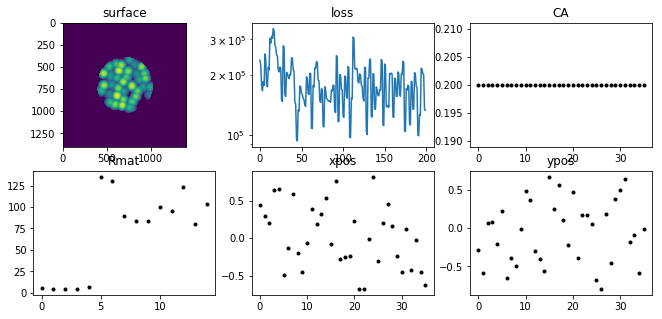

In [53]:
### Options:
from mpl_toolkits.axes_grid1 import make_axes_locatable
step_size = 1e-3#1e-6  works well for l2   e-15 for the cross correlation
use_averaged_gradient = True  # True: uses averaged gradient, False: uses single gradient 
optimizer_type = 'gd'           # options: 'gd': normal gradient descent, 'nesterov': nesterov acceleration
num_iterations =100
num_batches = 4
num_batches2 = 2
randomize_z = True   #If true, randomize zlist each epoch. If false, leave original order.

#optimizer=tf.train.GradientDescentOptimizer(learning_rate=step_size)
optimizer = tf.train.AdamOptimizer(learning_rate=step_size)
#optimizer=tf.train.MomentumOptimizer(learning_rate=step_size,momentum= 0.9, use_nesterov = True)
fig=plt.figure(figsize=(15,5))
losslist=[]
rmean=[]

defocus_grid=  1./(np.linspace(1/model.zmin_virtual, 1./model.zmax_virtual, model.Nz * num_batches)) #mm or dioptres
if num_batches>1:
    defocus_grid=  np.random.permutation(defocus_grid)

if optimizer_type == 'nesterov':
    tk = tf.constant(1,tf.float32)
    tkp = tf.constant(1,tf.float32)

    #xkp = model.variables
    nvars = np.shape(model.variables)[0]
    xk = []
    xkp = []
    [xk.append(tf.Variable(tf.zeros(model.Nlenslets))) for n in range(nvars)]
    [xkp.append(tf.Variable(tf.zeros(model.Nlenslets))) for n in range(nvars)]
    [tf.assign(xkp[n],model.variables[n]) for n in range(nvars)]



plt.subplot(2,4,6)
#plt.cla()
plt.plot(model.xpos.numpy(),'k.'); #plt.colorbar()
plt.title('xpos')

plt.subplot(2,4,7)
#plt.cla()
plt.plot(model.ypos.numpy(),'k.'); #plt.colorbar()
plt.title('ypos')
for i in range(num_iterations):
    if randomize_z:
        defocus_epoch = np.random.permutation(defocus_grid)
    else:
        defocus_epoch = defocus_grid
    
    for j in range(0, num_batches2):
        #for kz in range (0,10):
        if use_averaged_gradient == True:
            grad,lossvalue, Rmat =  averaged_gradient(model, loss, defocus_epoch,num_averages = num_batches)
        else: 
            grad, lossvalue, Rmat = gradients_and_scaling(model, loss, defocus_epoch[j*model.Nz:j*model.Nz+model.Nz])  # initial value 


        #grad,lossvalue, Rmat=gradient(model,loss)

       # new_xpos = model.xpos - step_size*grad[2]
       # new_ypos = model.xpos - step_size*grad[3] 
        #new_grad, test_dist, test_dist_bool = constrain_distances(model, new_xpos, new_ypos, grad) # apply constraint 


        # Gradient step
        if optimizer_type == 'gd':
            optimizer.apply_gradients(zip(grad,model.variables),global_step=tf.train.get_or_create_global_step())
            # Projection step
            #project_to_aper_keras(model)

        if optimizer_type == 'nesterov':

            optimizer.apply_gradients(zip(grad,model.variables),global_step=tf.train.get_or_create_global_step())


            # Projection step
            project_to_aper_keras(model)

            # Update variables for next loop
            tk = tkp
            [tf.assign(xk[n],xkp[n]) for n in range(nvars)]

            # Get state after project (gradient_step(yk))
            [tf.assign(xkp[n],model.variables[n]) for n in range(nvars)]

            #Acceleration
            tkp = 0.5*(1.0 + tf.sqrt(1.0 + 4*tf.square(tk)))

            bkp = (tk - 1)/tkp
            ykp = [xkp[n] + bkp*(xkp[n] - xk[n]) for n in range(nvars)]


            # Update model variables (yk)
            [model.variables[n].assign(ykp[n]) for n in range(nvars)]




        T,aper,T2=make_lenslet_tf_zern(model)

        losslist.append(lossvalue)

        # Plotting Everything 
        plt.subplot(2,4,1)
        plt.cla()
        plt.imshow(T.numpy())


        

        plt.title('surface')

        plt.subplot(2,4,2)
        plt.cla()
        plt.semilogy(losslist)
        plt.title('loss')

        plt.subplot(2,4,3)
        plt.cla()
        pl = plt.plot(model.mean_lenslet_CA.numpy(),'k.')
        plt.title('CA')
        
        plt.subplot(2,4,5)
        plt.cla()
        plt.plot(Rmat.numpy(),'k.'); #plt.colorbar()
        plt.title('Rmat')

#         plt.subplot(2,4,4)
#         plt.cla()
#         plt.plot(model.mean_lenslet_CA,'k.'); #plt.colorbar()
#         plt.title('Lenslet_CA')

        
        #pl = plt.plot(model.rlist.numpy(),'k.')
        #plt.title('radii')

#         plt.subplot(1,5,5)
#         plt.cla()
#         plt.plot(grad[-1][:,0].numpy())
#        # plt.plot(grad[-1][:,1].numpy())
#         #plt.plot(grad[-1][:,2].numpy())
#        # plt.plot(grad[-1][:,3].numpy())
#        # plt.plot(grad[-1][:,4].numpy())
#         plt.legend(('0', '1', '2', '3', '4'))


#         display.display(plt.gcf())
#         display.clear_output(wait=True)
        pl.clear()
        display.display(plt.gcf())
        display.clear_output(wait=True)
#     pl.remove?



#plt.colorbar()

In [ ]:
model.variables

In [ ]:
plt.imshow(T.numpy())
plt.colorbar()

In [ ]:
#save
# Save 
dict_best = {'x_best' : model.xpos.numpy(),
         'y_best': model.ypos.numpy(),
         'r_best': model.rlist,
         'zern_best': model.zernlist.numpy()}
name='250random2Iter'
scipy.io.savemat('/home/kyrollos/randoscope/BestAndWorst/best_init'+name+'.mat', dict_best)

In [ ]:
def sliceFormula(X,Y,z,params):
    xpos,ypos,rlist,r_lenslet,height,aperR,indexPoint=params
    aper=np.sqrt(X**2+Y**2) <= aperR
    if z<=height:        
        return aper
    else:
        T = np.zeros(len(X))
        inds=range(len(xpos))
        if (indexPoint>-1):
            inds=[indexPoint]
        for n in inds:
            #sph = np.real(np.sqrt(0j+Rlist[n]**2 - (xg-Xlist[n])**2 - (yg-Ylist[n])**2))-Rlist[n]+10
            sph1 = np.real(np.sqrt(0j+rlist[n]**2 - (X-xpos[n])**2 - (Y-ypos[n])**2))-np.real(np.sqrt(0j+rlist[n]**2-r_lenslet**2))-(z-height)
            T = np.maximum(T,sph1)
            T=(T>0)
        return (T)*aper
    

In [ ]:
model.zernlist

In [ ]:
# Options:
step_size = 1e-7   #1e-8 works well for l2
use_averaged_gradient = False  # True: uses averaged gradient, False: uses single gradient 
optimizer_type = 'gd'           # options: 'gd': normal gradient descent, 'nesterov': nesterov acceleration
num_iterations = 100
num_batches = 1
randomize_z = False   #If true, randomize zlist each epoch. If false, leave original order.

optimizer=tf.train.GradientDescentOptimizer(learning_rate=step_size)
#optimizer=tf.train.MomentumOptimizer(learning_rate=step_size,momentum= 0.9, use_nesterov = True)
fig=plt.figure(figsize=(15,5))
losslist=[]
rmean=[]

defocus_grid=  1./(np.linspace(1/model.zmin_virtual, 1./model.zmax_virtual, model.Nz * num_batches)) #mm or dioptres
    

if optimizer_type == 'nesterov':
    tk = tf.constant(1,tf.float32)
    tkp = tf.constant(1,tf.float32)

    #xkp = model.variables
    nvars = np.shape(model.variables)[0]
    xk = []
    xkp = []
    [xk.append(tf.Variable(tf.zeros(model.Nlenslets))) for n in range(nvars)]
    [xkp.append(tf.Variable(tf.zeros(model.Nlenslets))) for n in range(nvars)]
    [tf.assign(xkp[n],model.variables[n]) for n in range(nvars)]

    
for i in range(num_iterations):
    if randomize_z:
        defocus_epoch = np.random.permutation(defocus_grid)
    else:
        defocus_epoch = defocus_grid
    for j in range(0, num_batches):
        if use_averaged_gradient == True:
            grad,lossvalue, Rmat =  averaged_gradient(model_noaber, loss, num_averages = 10)
        else: 
            grad, lossvalue, Rmat = gradients_and_scaling(model_noaber, loss, defocus_epoch[j*model.Nz:j*model.Nz+model.Nz])  # initial value 


        #grad,lossvalue, Rmat=gradient(model,loss)

       # new_xpos = model.xpos - step_size*grad[2]
       # new_ypos = model.xpos - step_size*grad[3] 
        #new_grad, test_dist, test_dist_bool = constrain_distances(model, new_xpos, new_ypos, grad) # apply constraint 


        # Gradient step
        if optimizer_type == 'gd':
            optimizer.apply_gradients(zip(grad,model_noaber.variables),global_step=tf.train.get_or_create_global_step())
            # Projection step
            project_to_aper_keras(model_noaber)

        if optimizer_type == 'nesterov':

            optimizer.apply_gradients(zip(grad,model.variables),global_step=tf.train.get_or_create_global_step())


            # Projection step
            project_to_aper_keras(model)

            # Update variables for next loop
            tk = tkp
            [tf.assign(xk[n],xkp[n]) for n in range(nvars)]

            # Get state after project (gradient_step(yk))
            [tf.assign(xkp[n],model_noaber.variables[n]) for n in range(nvars)]

            #Acceleration
            tkp = 0.5*(1.0 + tf.sqrt(1.0 + 4*tf.square(tk)))

            bkp = (tk - 1)/tkp
            ykp = [xkp[n] + bkp*(xkp[n] - xk[n]) for n in range(nvars)]


            # Update model variables (yk)
            [model_noaber.variables[n].assign(ykp[n]) for n in range(nvars)]




        T,aper,T2=make_lenslet_tf_zern(model_noaber)

        losslist.append(lossvalue)

        # Plotting Everything 
        plt.subplot(1,4,1)
        plt.cla()
        plt.imshow(T.numpy())
        plt.title('surface')

        plt.subplot(1,4,2)
        plt.cla()
        plt.semilogy(losslist)
        plt.title('loss')

        plt.subplot(1,4,3)
        plt.cla()
        pl = plt.plot(Rmat.numpy(),'k.')
        plt.title('Rmat')

        plt.subplot(1,4,4)
        plt.cla()
        #plt.imshow(np.abs(T-T2)); #plt.colorbar()
        
        #pl = plt.plot(model.rlist.numpy(),'k.')
        #plt.title('radii')


        display.display(plt.gcf())
        display.clear_output(wait=True)
        pl.clear()
        display.display(plt.gcf())
        display.clear_output(wait=True)
#     pl.remove?
    


#cbar = fig.colorbar(rshow)

In [ ]:
Tnone,_,_= make_lenslet_tf_zern(model_noaber)
Tsome,_,_ =make_lenslet_tf_zern(model)

plt.imshow(Tnone-Tsome)

In [ ]:
Rnone = model_noaber(0)
Rsome = model(0)

plt.plot(Rnone.numpy()), 'x'; plt.plot(Rsome.numpy(), 'o'); plt.legend(('no aberrations', 'aberrations'));

In [ ]:
T1,aper,T2=make_lenslet_tf_zern(model)
plt.figure(figsize = (15,5))
plt.subplot(1,3,1), plt.imshow(T2); plt.colorbar(); plt.title('no aberrations')
plt.subplot(1,3,2), plt.imshow(T1); plt.colorbar(); plt.title('with aberrations')
plt.subplot(1,3,3), plt.imshow(np.abs(T1-T2)); plt.colorbar(); plt.title('difference')

In [ ]:
# Compare spectra
def radial_profile(data, center):
    y, x = np.indices((data.shape))
    r = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    r = r.astype(np.int)

    tbin = np.bincount(r.ravel(), data.ravel())
    nr = np.bincount(r.ravel())
    radialprofile = tbin / nr
    return radialprofile

def plot_spectra(model):
    T,aper=make_lenslet_tf(model)
    #model = Model()
    psf_stack = model.gen_psf_stack(T, aper, 0.)
    stack_spectrum = model.gen_stack_spectrum(psf_stack)
    f, ax = plt.subplots(1,model.Nz,figsize=(25,3))
    for n in range(len(ax)):
        ax[n].plot((model.dc_mask*tf.abs(stack_spectrum[n])).numpy()[0,:model.samples[1]//2],'r',label='spectrum z{}'.format(n))
        ax[n].plot(model.target_F.numpy()[0,:model.samples[1]//2],'k',label='Target res: {}'.format(model.target_res))
        ax[n].legend()
        ax[n].set_title('Spectrum')
        ax[n].set_ylim(top=5)
        
def compare_spectra(model_init, model_opt):
    T,aper=make_lenslet_tf(model_init)
    #model = Model()
    psf_stack = model_init.gen_psf_stack(T, aper, 0.)
    stack_spectrum_init = model_init.gen_stack_spectrum(psf_stack)
    
    T,aper=make_lenslet_tf(model_opt)
    #model = Model()
    psf_stack = model_opt.gen_psf_stack(T, aper, 0.)
    stack_spectrum_opt = model_opt.gen_stack_spectrum(psf_stack)
    
    f, ax = plt.subplots(1,model.Nz,figsize=(25,3))
    for n in range(len(ax)):
        ax[n].plot((model_init.dc_mask*tf.abs(stack_spectrum_init[n])).numpy()[0,:model.samples[1]//2],'r',label='Initial spectrum z{}'.format(n))
        ax[n].plot((model_opt.dc_mask*tf.abs(stack_spectrum_opt[n])).numpy()[0,:model.samples[1]//2],'k',label='Optimized spectrum z{}'.format(n))
        ax[n].legend()
        ax[n].set_title('Spectrum')
        ax[n].set_ylim(top=5)
        
def plot_spectra_radial(model):
    T,aper=make_lenslet_tf(model)
    #model = Model()
    psf_stack = model.gen_psf_stack(T, aper, 0.)
    stack_spectrum = model.gen_stack_spectrum(psf_stack)
    f, ax = plt.subplots(1,model.Nz,figsize=(25,3))
    for n in range(len(ax)):
        radprof = radial_profile((model.dc_mask*tf.abs(stack_spectrum[n])).numpy(),(0,0))
        ax[n].plot(radprof[:model.samples[1]//2],'r',label='spectrum z{}'.format(n))
        ax[n].plot(model.target_F.numpy()[0,:model.samples[1]//2],'k',label='Target res: {}'.format(model.target_res*100//1))
        ax[n].legend()
        ax[n].set_title('Spectrum')
        ax[n].set_ylim(bottom=0,top=100)

        
# radial average
def compare_spectra_radial(model_init, model_opt):
    T,aper=make_lenslet_tf(model_init)
    #model = Model()
    psf_stack = model_init.gen_psf_stack(T, aper, 0.)
    stack_spectrum_init = model_init.gen_stack_spectrum(psf_stack)
    
    T,aper=make_lenslet_tf(model_opt)
    #model = Model()
    psf_stack = model_opt.gen_psf_stack(T, aper, 0.)
    stack_spectrum_opt = model_opt.gen_stack_spectrum(psf_stack)
    
    f, ax = plt.subplots(1,model.Nz,figsize=(25,3))
    for n in range(len(ax)):
        
        radprof_init = radial_profile((model_init.dc_mask*tf.abs(stack_spectrum_init[n])).numpy(),(0,0))
        ax[n].plot(radprof_init[:model_init.samples[1]//2],'r',label='Init z{}'.format(n))
        #ax[n].plot((model_init.dc_mask*tf.abs(stack_spectrum_init[n])).numpy()[0,:model.samples[1]],'r',label='Initial spectrum z{}'.format(n))
        #ax[n].plot((model_opt.dc_mask*tf.abs(stack_spectrum_opt[n])).numpy()[0,:model.samples[1]],'k',label='Optimized spectrum z{}'.format(n))
        radprof_opt = radial_profile((model_opt.dc_mask*tf.abs(stack_spectrum_opt[n])).numpy(),(0,0))
        ax[n].plot((radprof_opt)[:model_init.samples[1]//2],'k',label='Opt z{}'.format(n))
        ax[n].legend()
        ax[n].set_title('Radially averaged spectrum')
        ax[n].set_ylim(bottom=0)
    
#model_opt = Model()
#model_opt.load_weights('C:\\Users\\herbtipa\\logsumexp_1000_2p5.hd5')
plot_spectra_radial(model_init)


#re_init_model()
plot_spectra_radial(model)
compare_spectra_radial(model_init, model)

In [ ]:
Ropt = model(0).numpy()
xcorr_opt = calc_max_xcorr(model)
Rinit = model_noaber(0).numpy()
xcorr_init = calc_max_xcorr(model_noaber)

f, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(Ropt[:model.Nz], 'rx',label='aberrations')
ax[0].plot(Rinit[:model.Nz],  'k.',label='no aberrations')
ax[0].legend()
ax[0].set_title('Spectral fitting')
ax[0].set_ylabel('loss')
ax[0].set_xlabel('z-plane')


ax[1].plot(xcorr_opt, 'rx',label='aberrations')
ax[1].plot(xcorr_init,  'k.',label='no aberrations')
ax[1].legend()
ax[1].set_title('Cross correlations')
ax[0].set_ylabel('loss')
ax[0].set_xlabel('z-plane')

In [ ]:
Ropt = model(0).numpy()
xcorr_opt = calc_max_xcorr(model)
Rinit = model_init(0).numpy()
xcorr_init = calc_max_xcorr(model_init)

f, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(Ropt[:model.Nz], 'rx',label='optimized')
ax[0].plot(Rinit[:model.Nz],  'k.',label='init')
ax[0].legend()
ax[0].set_title('Spectral fitting')
ax[0].set_ylabel('loss')
ax[0].set_xlabel('z-plane')


ax[1].plot(xcorr_opt, 'rx',label='optimized')
ax[1].plot(xcorr_init,  'k.',label='init')
ax[1].legend()
ax[1].set_title('Cross correlations')
ax[0].set_ylabel('loss')
ax[0].set_xlabel('z-plane')

In [ ]:
plt.imshow(model.target_F*model.dc_mask)
plt.colorbar()

In [ ]:
Fcorr = tf.conj(spect[0])*spect[0]
acorr = tf_fftshift(tf.abs(tf.ifft2d(Fcorr)))
acorr_test=acorr
plt.imshow(acorr_test)
plt.colorbar()

In [ ]:
fig1, ax1 = plt.subplots(1,2,figsize=(15,5))
test2 = model.gen_psf_stack(T, aper, 0., zplanes =defocus_grid[0])

spect=model.gen_stack_spectrum(test2)
vrange = 20
f1 = ax1[0].imshow(tf_fftshift(np.abs(spect[0].numpy()) - 0*np.abs(model.target_F.numpy())))
fig1.colorbar(f1,ax=ax1[0])

test3 = model_init.gen_psf_stack(Tinit, aper,0., zplanes =defocus_grid[0])

spect3=model.gen_stack_spectrum(test3)
f2 = ax1[1].imshow(tf_fftshift(np.abs(0*spect3[-1].numpy()) + 1*np.abs(model.target_F.numpy())))
fig1.colorbar(f1,ax=ax1[1])
print(np.sum(np.abs(np.abs(spect3[-1].numpy()) - 1*np.abs(model.target_F.numpy()))*model.dc_mask*np.abs(model.target_F.numpy()>.001)))
print(np.sum(np.abs(np.abs(spect[-1].numpy()) - 1*np.abs(model.target_F.numpy()))*model.dc_mask*np.abs(model.target_F.numpy()>.001)))
#print(tf.reduce_max(spect[0]))

In [ ]:
plt.imshow(np.abs(model.target_F.numpy())>.001)

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
target_real = tf.ifft2d(tf.complex(model.target_F, 0.))
# f2 = ax[0].imshow((tf.real(tf.ifft2d(spect[0]*tf.conj(spect[0]))) - tf_fftshift(model.target_airy))[0:50,0:50])
f2 = ax[0].imshow(tf_fftshift(tf.real(tf.ifft2d(spect[0]*tf.conj(spect[0]))) - 0*(tf.real(target_real) )))
f1 = ax[1].imshow(tf_fftshift(tf.real(target_real)))
fig.colorbar(f1)
fig.colorbar(f2, ax=ax[0])


In [ ]:
psf_spect=tf_fftshift(tf.real(tf.ifft2d(spect[-1]*tf.conj(spect[-1]))))
fig, ax = plt.subplots(1,2,figsize=(15,5))
f2 = ax[0].imshow(tf.to_float(psf_spect>.1)*(tf.real(psf_spect)))
fig.colorbar(f2, ax=ax[0])

In [ ]:
plt.imshow(model.target_airy)
plt.colorbar()
print(tf.reduce_max(model.target_airy))

In [ ]:
plt.imshow(tf.ifft2d(model.target_F))

In [ ]:
def plot_psf_stack(model):
    T,aper,T2=make_lenslet_tf_zern(model)
    test2 = model.gen_psf_stack(T, aper, 0., zplanes=0)
    test22 = model.gen_psf_stack(T2, aper, 0., zplanes=0)
    
    

        #test = model.gen_stack_spectrum(test2)
    #test3=model.gen_correlation_stack(test)
    #ax[0].imshow(T)
    #plt.plot((model.dc_mask * tf.abs(test[1]))[-1,:200].numpy())
    #plt.plot((model.dc_mask * model.target_F)[-1,:200].numpy())
    for z in range(len(test2)):
        fig = plt.figure(figsize=(15,5))
        plt.cla()
        plt.subplot(1,2,1),
        plt.imshow(test2[z].numpy())
        plt.subplot(1,2,2), plt.imshow(test22[z].numpy())
        #plt.plot(np.abs(test3[z][model.samples[0],:]))

        display.display(fig)
        display.clear_output(wait=True)
        plt.pause(.5)


In [ ]:
#z_list = 1./(np.linspace(1/model.zmin_virtual, 1./model.zmax_virtual, 20)) #mm or dioptres
plot_psf_stack(model)

In [ ]:
dpi = 100
T,aper,T2=make_lenslet_tf_zern(model)
test2 = model.gen_psf_stack(T, aper, 0., zplanes=0)
test22 = model.gen_psf_stack(T2, aper, 0., zplanes=0)
def ani_frame():
    fig = plt.figure()
    ax = fig.add_subplot(121)
    ax.set_aspect('equal')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    im = ax.imshow(test2[0])
    #im.set_clim([0,1])
    ax2 = fig.add_subplot(122)
    ax2.set_aspect('equal')
    ax2.get_xaxis().set_visible(False)
    ax2.get_yaxis().set_visible(False)

    im2 = ax2.imshow(test22[0])
    
    fig.set_size_inches([5,5])


    tight_layout()


    def update_img(n):
        im.set_data(test2[n])
        im2.set_data(test22[n])
        return im

    #legend(loc=0)
    ani = animation.FuncAnimation(fig,update_img,np.arange(0, len(test2)),interval=500)
    plt.show()
    writer = animation.writers['imagemagick'](fps=2)

    ani.save('AberrationPSF_8zernikes_3000iter.gif',writer=writer,dpi=dpi)
    return ani

In [ ]:
#!brew install imagemagick

ani_frame()


In [ ]:
model.variables

fig, ax = plt.subplots()

x = np.arange(0, 2*np.pi, 0.01)
line, = ax.plot(x, np.sin(x))


def animate(i):
    line.set_ydata(np.sin(x + i/10.0))  # update the data
    return line,


# Init only required for blitting to give a clean slate.
def init():
    line.set_ydata(np.ma.array(x, mask=True))
    return line,

ani = animation.FuncAnimation(fig, animate, np.arange(1, 200), init_func=init,
                              interval=25, blit=True)
plt.show()

In [ ]:
model.variables

In [ ]:
zplanes = 1./(np.linspace(1/model.zmin_virtual, 1./model.zmax_virtual, 20))
zplanes

In [ ]:
U_in = tf_exp(model.k*(model.Grin[0]+defocus_grid[0] -defocus_grid[0]*tf.sqrt(1+tf.square(model.ygm/defocus_grid[0])+tf.square(model.xgm/defocus_grid[0])) )) #negative already included
    

In [ ]:
U_out = U_in * tf_exp((model.k*(model.ior-1)*T + 0))

In [ ]:
T

In [ ]:
model.zernlist

In [ ]:
def psf_slider(z, psf_stack):
    
    #test = model.gen_stack_spectrum(test2)
    fig = plt.figure(figsize=(15,10))
    plt.imshow(psf_stack[z].numpy())
    plt.show()
    return fig

    

In [ ]:
z_list = 1./(np.linspace(1/model.zmin_virtual, 1./model.zmax_virtual, 15)) #mm or dioptres


In [ ]:
T,aper=make_lenslet_tf(model)
test2 = model.gen_psf_stack(T, aper, .5, zplanes_opt = z_list)
np.shape(test2[0].numpy())

In [ ]:
from ipywidgets import interact, widgets
fig = plt.figure(figsize=(15,10))
interact(psf_slider, z = widgets.IntSlider(min=1, max = 15, step=1, value=1), test2)

In [ ]:
plot_psf_stack(model)

In [ ]:
T,aper,T2=make_lenslet_tf_zern(model)
test2 = model.gen_psf_stack(T, aper, 0., zplanes = 1./(np.linspace(1/model.zmin_virtual, 1./model.zmax_virtual, 40)))
test22 = model.gen_psf_stack(Tinit, aper, 0., zplanes = 1./(np.linspace(1/model.zmin_virtual, 1./model.zmax_virtual, 40)))
    

## Function to run reconstructions in loop (to run many initializations)

In [ ]:
Tmat=T.numpy()
save_dict = {'T': Tmat}
scipy.io.savemat('/home/kyrollos/randoscope/data_2_20_2019/learnedSurface.mat' , save_dict)

In [ ]:
psf_opt=[]
psf_init=[]
for i in range(len(test2)):
    psf_opt.append(np.array(test2[i]))
    psf_init.append(np.array(test22[i]))
save_dict = {'psf_opt': psf_opt,'psf_init':psf_init}
scipy.io.savemat('/home/kyrollos/randoscope/data_2_20_2019/learnedPSF.mat' , save_dict)

In [ ]:
len(test2)

In [ ]:
def run_opt(iterations, model, ind, CA):
    
    xpos0 = model.xpos.numpy()
    ypos0 = model.ypos.numpy()
    rlist0 = model.rlist.numpy()
    offset0 = model.lenslet_offset.numpy()
    
    step_size = 1e-8
    optimizer=tf.train.GradientDescentOptimizer(learning_rate=step_size)

    losslist=[]
    for i in range(iterations):
        
        num_grads = 10
        grad_averaged = 1/num_grads * gradients_and_scaling(model, loss)
        for g in range(0,num_grads-1):
            grads, lossvalue = gradients_and_scaling(model, loss)
        
            for grad_ind in range(0,len(model.variables)):
                grad_averaged[grad_ind] = grad_averaged[grad_ind] + 1/num_grads * grads[grad_ind]

        
        optimizer.apply_gradients(zip(grads_averaged,model.variables),global_step=tf.train.get_or_create_global_step())
        project_to_aper_keras(model)
        T,aper=make_lenslet_tf(model)

        losslist.append(lossvalue.numpy())
        
    xposf = model.xpos.numpy()
    yposf = model.ypos.numpy()
    rlistf = model.rlist.numpy()
    offsetf = model.lenslet_offset.numpy()    
    save_dict = {'xpos0': xpos0,
             'ypos0': ypos0,
             'rlist0': rlist0,
             'offset0': offset0,
            'losses': losslist,
             'xposf': xposf,
             'yposf': yposf,
             'rlistf': rlistf,
             'offsetf': offsetf,}
    
    save_extension = 'test_'+ str(CA)+ '_' + str(ind)+'_initial_loss_' + str(losslist[0])+ '_final_loss_' + str(losslist[-1]) + '.mat'
    scipy.io.savemat('/home/kyrollos/randoscope/data_1_12_2019/' + save_extension, save_dict)
    

In [ ]:
# Re-initialize model
model.xpos.assign(xinit)
model.ypos.assign(yinit)
model.lenslet_offset.assign(offsetinit)
model.rlist.assign(rinit)
print(model.xpos)

In [ ]:
#[model.variables[n].assign(init_vars) for n in range(nvars)]
# Gradient descent
step_size = 1e-9
optimizer=tf.train.GradientDescentOptimizer(learning_rate=step_size)
fig=plt.figure(figsize=(15,5))
losslist=[]
rmean=[]
tk = tf.constant(1,tf.float32)
tkp = tf.constant(1,tf.float32)
# xk = model.variables
# xkp = model.variables
# nvars = np.shape(xk)[0]
for i in range(70):
    grad,lossvalue, Rmat=gradient(model,loss_sum)

   # new_xpos = model.xpos - step_size*grad[2]
   # new_ypos = model.xpos - step_size*grad[3] 

    #new_grad, test_dist, test_dist_bool = constrain_distances(model, new_xpos, new_ypos, grad) # apply constraint 
    #print(new_grad)
    grad[1] = grad[1] * 100000  #Radius
    grad[2]=grad[2]*10000 # X
    grad[3]=grad[3]*10000 # Y
    #grad[2] = grad[2]*new_grad[0,:]*10000
   # grad[3] = grad[3]*new_grad[1,:]*10000   # update the gradient
#    grad[1] = grad[1]*
    
    #grads=remove_nan_gradients(grad)
    #print(grads)
    
    # Gradient step
    optimizer.apply_gradients(zip(grad,model.variables),global_step=tf.train.get_or_create_global_step())
    
    # Projection step
    project_to_aper_keras(model)
    

    
    T,aper=make_lenslet_tf(model)

    losslist.append(lossvalue)
    plt.subplot(1,3,1)
    plt.cla()
    #plt.plot(model.xpos.numpy(),model.ypos.numpy(),'o')
    #plt.axis('equal')
    #rmean.append(tf.reduce_mean(model.rlist.numpy()))
    #plt.plot(rmean)
    plt.imshow(T.numpy())
    plt.subplot(1,3,2)
    plt.cla()
    plt.semilogy(losslist)
    
    
    plt.subplot(1,3,3)
    plt.cla()

    #rshow = plt.imshow(np.tril(Rmat[model.Nz+1:-1])
#     cbar = fig.colorbar(rshow)    
    pl = plt.plot(Rmat.numpy(),'k.')
    
    display.display(plt.gcf())
    display.clear_output(wait=True)
    pl.clear()
#     cbar.remove()
# cbar = fig.colorbar(rshow)

In [ ]:
fig = plt.figure(figsize=(15,3))
T,aper=make_lenslet_tf(model)
test2 = model.gen_psf_stack(T, aper, .5)
test = model.gen_stack_spectrum(test2)
test4=model.gen_correlation_stack(test)
#ax[0].imshow(T)


# for z in range(len(test4)):

#     #ax[1].imshow(tf_fftshift(tf.abs((test[z] * tf.conj(test[z])))), vmin = 0, vmax = 50)
#     #ax[2].imshow(tf_fftshift(tf.abs((test[z] * tf.conj(test[z]))) - model.target_F), vmin = -50, vmax = 50)
#     plt.cla()
#     #ax[1].imshow((tf.real((test[z] * tf.conj(test[z])))), vmax = 50)
#     plt.subplot(1,2,1)
#     plt.plot(np.abs(test3[z][model.samples[0],:]))
    
#     plt.subplot(1,2,2)
#     plt.plot(np.abs(test4[z][model.samples[0],:]))

#     display.display(fig)
#     display.clear_output(wait=True)
#     plt.pause(.5)

In [ ]:
plt.figure(figsize=(20,15))
for z in range(7):

    #ax[1].imshow(tf_fftshift(tf.abs((test[z] * tf.conj(test[z])))), vmin = 0, vmax = 50)
    #ax[2].imshow(tf_fftshift(tf.abs((test[z] * tf.conj(test[z]))) - model.target_F), vmin = -50, vmax = 50)
    #plt.cla()
    #ax[1].imshow((tf.real((test[z] * tf.conj(test[z])))), vmax = 50)
    plt.subplot(7,2,z*2+1)
    ind = (model.Nz+1) * (z)
    plt.plot(np.abs(test3[ind][model.samples[0],:]))
    
    plt.subplot(7,2,z*2+2)
    plt.plot(np.abs(test4[ind][model.samples[0],:]))

    #display.display(fig)
    #display.clear_output(wait=True)
    #plt.pause(.5)

In [ ]:
plt.imshow(tf.reshape(model(0),(model.Nz, model.Nz)))
plt.colorbar()

In [ ]:
plt.plot(np.sort(1/model.rlist.numpy()),'o')

In [ ]:
model.lenslet_offset

In [ ]:
T,aper=make_lenslet_tf(model)
test2 = model.gen_psf_stack(T, aper, 0.5)
test = model.gen_stack_spectrum(test2)
fig = plt.figure()

f,ax = plt.subplots(1,2,figsize=(20,20))

ax[0].imshow(T)


for z in range(model.Nz):
    #ax[1].imshow((tf.real((test[z] * tf.conj(test[z])))) - model.target_F, vmax = 50)
    im_disp = ax[1].imshow((tf.real((test2[z]))),vmax = .3)
    cbar = plt.colorbar(im_disp, ax=ax[1])
    display.display(f)
    display.clear_output(wait=True)
    cbar.remove()
    #plt.pause(1)

In [ ]:
def animate_zstack(i):
#    ax[1].clear()
    ax[1].imshow(tf.real(test2[i]),vmax = .1)

In [ ]:
#model.save_weights('C:\\Users\\herbtipa\\lenslets_one_per_depth.hd5',overwrite=False)

In [ ]:
f,ax = plt.subplots(1,2,figsize=(20,20))
ax[0].imshow(T)
ani = animation.FuncAnimation(f, animate_zstack, frames = range(model.Nz), interval = 500, repeat = False)
# plt.show(ani)
#Writer = animation.writers['ffmpeg']

# HTML(ani.to_html5_video())
for i in range(model.Nz):
    animate_zstack(i)
    display.display(f)
    display.clear_output(wait=True)
    f.savefig('C:\\Users\\herbtipa\\foo_{}.png'.format(i))
    



In [ ]:
#jacobian=[]
#for i in range (model.Nz**2):
#    with tf.GradientTape() as tape:
#        #tape.watch(model.variables)
#        R=model(0)
#        jacobian.append(tape.gradient(R[i], model.variables))
